## 1. Setup - ייבוא ספריות והגדרת נתיבים

In [61]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests
from bs4 import BeautifulSoup
import time
from datetime import datetime

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'DejaVu Sans'

# Helper to find project root
def _find_root(start=None):
    p = start or Path.cwd()
    for _ in range(6):
        if (p / 'data').exists() or (p / '.git').exists() or (p / 'notebooks').exists():
            return p
        p = p.parent
    return Path.cwd()

# Setup paths
ROOT = _find_root()
DATA_DIR = ROOT / 'data'
MATCHES_DIR = DATA_DIR / 'matches'
PLAYOFF_DIR = DATA_DIR / 'playoffs'
INTERIM_DIR = DATA_DIR / 'interim'
SCRAPED_DATA_DIR = INTERIM_DIR / 'scraped_standings'
SCRAPED_GAPS_FILE = SCRAPED_DATA_DIR / 'all_seasons_gaps_scraped.csv'
FIG_DIR = ROOT / 'reports' / 'figures'

# Create directories
SCRAPED_DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Environment setup complete")
print(f"   ROOT: {ROOT}")
print(f"   DATA_DIR: {DATA_DIR}")
print(f"   SCRAPED_DATA_DIR: {SCRAPED_DATA_DIR}")
print(f"   FIG_DIR: {FIG_DIR}")

✅ Environment setup complete
   ROOT: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks
   DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data
   SCRAPED_DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings
   FIG_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures


## 2. Transfermarkt Scraping Functions
### פונקציות לסקרייפ נתונים מדויקים מטרנספרמרקט

In [62]:
def scrape_transfermarkt_standings(season_str, round_num):
    """
    Scrape standings table from Transfermarkt for a specific round
    
    Args:
        season_str: Season like "2017/18"
        round_num: Round number (1-33)
    
    Returns:
        DataFrame with columns: rank, team, matches, wins, draws, losses, goals, goal_diff, points
        Or None if failed
    """
    # Convert season string to Transfermarkt format
    year = int(season_str.split('/')[0])
    
    # Build URL
    url = f"https://www.transfermarkt.com/ligat-haal/spieltagtabelle/wettbewerb/ISR1?saison_id={year}&spieltag={round_num}"
    
    # Headers to mimic a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find the standings table
        table = soup.find('table', {'class': 'items'})
        
        if not table:
            return None
        
        # Parse table rows
        rows = table.find('tbody').find_all('tr')
        
        standings_list = []
        
        for row in rows:
            cells = row.find_all('td')
            
            if len(cells) < 10:
                continue
            
            # Extract data from cells
            rank = cells[0].text.strip()
            team = cells[2].text.strip()
            matches = int(cells[3].text.strip())
            wins = int(cells[4].text.strip())
            draws = int(cells[5].text.strip())
            losses = int(cells[6].text.strip())
            goals = cells[7].text.strip()
            goal_diff = int(cells[8].text.strip())
            points = int(cells[9].text.strip())
            
            standings_list.append({
                'rank': rank,
                'team': team,
                'matches': matches,
                'wins': wins,
                'draws': draws,
                'losses': losses,
                'goals': goals,
                'goal_diff': goal_diff,
                'points': points
            })
        
        if not standings_list:
            return None
        
        df = pd.DataFrame(standings_list)
        return df
        
    except Exception as e:
        print(f"  ⚠️ Error scraping {season_str} round {round_num}: {e}")
        return None

print("✅ Scraping function created!")

✅ Scraping function created!


In [63]:
def calculate_gap_with_scraping(season_str):
    """
    Calculate points gap between top 2 teams using Transfermarkt scraped standings
    
    Args:
        season_str: Season like "2017/18"
    
    Returns:
        DataFrame with round-by-round gap, or None if error
    """
    # Get the final round number from existing match data
    matches_file = MATCHES_DIR / f'matches_{season_str.replace("/", "_")}_ligat_haal_transfermarkt.csv'
    
    if not matches_file.exists():
        print(f"❌ Match file not found: {season_str}")
        return None
    
    matches_df = pd.read_csv(matches_file)
    
    # Determine correct number of rounds based on number of teams
    # Transfermarkt shows standings by round for regular season
    num_teams = len(set(matches_df['home'].unique()) | set(matches_df['away'].unique()))
    
    if num_teams == 12:
        max_round = 33  # 12 teams: 3 rounds × 11 matches = 33 rounds
    elif num_teams == 14:
        max_round = 26  # 14 teams: (14-1) × 2 = 26 rounds
    elif num_teams == 16:
        max_round = 30  # 16 teams: (16-1) × 2 = 30 rounds
    else:
        # Fallback: calculate from unique rounds in data
        max_round = len(matches_df['round'].unique())
    
    print(f"📊 {season_str}: {num_teams} teams → {max_round} rounds. Scraping...")
    
    gaps_data = []
    failed_rounds = []
    
    for round_num in range(1, max_round + 1):
        # Scrape standings for this round
        standings = scrape_transfermarkt_standings(season_str, round_num)
        
        if standings is None or len(standings) < 2:
            failed_rounds.append(round_num)
            continue
        
        # Get top 2 teams
        top1 = standings.iloc[0]
        top2 = standings.iloc[1]
        
        gap = top1['points'] - top2['points']
        
        gaps_data.append({
            'season': season_str,
            'round': round_num,
            'leader': top1['team'],
            'leader_points': top1['points'],
            'second': top2['team'],
            'second_points': top2['points'],
            'gap': gap
        })
        
        # Small delay to avoid overwhelming the server
        time.sleep(0.3)
    
    if len(gaps_data) == 0:
        print(f"  ❌ No data collected for {season_str}")
        return None
    
    if failed_rounds:
        print(f"  ⚠️ Failed rounds: {failed_rounds[:5]}{'...' if len(failed_rounds) > 5 else ''}")
    
    df = pd.DataFrame(gaps_data)
    print(f"  ✅ Collected {len(df)}/{max_round} rounds")
    
    return df

print("✅ Gap calculation function created!")

✅ Gap calculation function created!


## 3. Load/Scrape Regular Season Data
### טעינה או סקרייפ נתוני העונה הרגילה

In [64]:
# Check if cached data exists
print(f"📁 Cache directory: {SCRAPED_DATA_DIR}")
print(f"📄 Cache file: {SCRAPED_GAPS_FILE}")
print()

if SCRAPED_GAPS_FILE.exists():
    print("✅ Cached data found! Loading from file...")
    all_scraped_gaps_df = pd.read_csv(SCRAPED_GAPS_FILE)
    
    print(f"\n📊 Loaded data:")
    print(f"   Total rows: {len(all_scraped_gaps_df):,}")
    print(f"   Seasons: {all_scraped_gaps_df['season'].nunique()}")
    print(f"   Season range: {all_scraped_gaps_df['season'].min()} to {all_scraped_gaps_df['season'].max()}")
    
    cached_seasons = sorted(all_scraped_gaps_df['season'].unique())
    print(f"\n   Cached seasons ({len(cached_seasons)}):")
    for s in cached_seasons:
        count = len(all_scraped_gaps_df[all_scraped_gaps_df['season'] == s])
        print(f"      {s}: {count} rounds")
    
else:
    print("⚠️ No cached data found. Will scrape from Transfermarkt.")
    all_scraped_gaps_df = None

📁 Cache directory: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings
📄 Cache file: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\interim\scraped_standings\all_seasons_gaps_scraped.csv

✅ Cached data found! Loading from file...

📊 Loaded data:
   Total rows: 527
   Seasons: 19
   Season range: 2006/07 to 2024/25

   Cached seasons (19):
      2006/07: 33 rounds
      2007/08: 33 rounds
      2008/09: 33 rounds
      2009/10: 30 rounds
      2010/11: 30 rounds
      2011/12: 30 rounds
      2012/13: 26 rounds
      2013/14: 26 rounds
      2014/15: 26 rounds
      2015/16: 26 rounds
      2016/17: 26 rounds
      2017/18: 26 rounds
      2018/19: 26 rounds
      2019/20: 26 rounds
      2020/21: 26 rounds
      2021/22: 26 rounds
      2022/23: 26 rounds
      2023/24: 26 rounds
      2024/25: 26 rounds


In [65]:
# If no cache, scrape all seasons
if all_scraped_gaps_df is None:
    print("="*80)
    print("🚀 SCRAPING ALL SEASONS FROM TRANSFERMARKT")
    print("="*80)
    print()
    
    # Define all seasons
    all_seasons = [
        '2006/07', '2007/08', '2008/09',  # 12 teams - 33 rounds
        '2009/10', '2010/11', '2011/12',  # 16 teams - 30 rounds
        '2012/13', '2013/14', '2014/15', '2015/16', '2016/17',  # 14 teams - 26 rounds
        '2017/18', '2018/19', '2019/20', '2020/21', '2021/22',
        '2022/23', '2023/24', '2024/25'
    ]
    
    print(f"Total seasons to scrape: {len(all_seasons)}")
    print(f"Estimated time: ~{len(all_seasons) * 0.8:.1f} minutes")
    print()
    print("Starting scraping...")
    print()
    
    all_seasons_gaps = []
    failed_seasons = []
    
    start_time = time.time()
    
    for i, season in enumerate(all_seasons, 1):
        print(f"[{i}/{len(all_seasons)}] Processing {season}...")
        
        gap_df = calculate_gap_with_scraping(season)
        
        if gap_df is not None:
            all_seasons_gaps.append(gap_df)
            print(f"      ✅ Success! {len(gap_df)} rounds collected")
        else:
            failed_seasons.append(season)
            print(f"      ❌ Failed to collect data for {season}")
        
        print()
    
    elapsed = time.time() - start_time
    
    print("="*80)
    print(f"✅ SCRAPING COMPLETED in {elapsed/60:.1f} minutes")
    print("="*80)
    print()
    
    if failed_seasons:
        print(f"⚠️ Failed seasons ({len(failed_seasons)}): {', '.join(failed_seasons)}")
        print()
    
    # Combine all data
    all_scraped_gaps_df = pd.concat(all_seasons_gaps, ignore_index=True)
    
    print(f"📊 Total data collected:")
    print(f"   Seasons: {all_scraped_gaps_df['season'].nunique()}")
    print(f"   Total rounds: {len(all_scraped_gaps_df)}")
    print(f"   Average rounds per season: {len(all_scraped_gaps_df) / all_scraped_gaps_df['season'].nunique():.1f}")
    print()
    
    # Save to cache
    all_scraped_gaps_df.to_csv(SCRAPED_GAPS_FILE, index=False)
    file_size = SCRAPED_GAPS_FILE.stat().st_size / 1024  # KB
    
    print(f"💾 Data saved to: {SCRAPED_GAPS_FILE}")
    print(f"   File size: {file_size:.1f} KB")
    print()
else:
    print("✅ Using cached data (no scraping needed)")

✅ Using cached data (no scraping needed)


## 4. Regular Season Analysis
### ניתוח העונה הרגילה - סטטיסטיקות ופילוחים

In [66]:
# Calculate statistics per season
season_stats = []

for season in all_scraped_gaps_df['season'].unique():
    season_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season]
    
    avg_gap = season_data['gap'].mean()
    final_gap = season_data.iloc[-1]['gap']
    max_gap = season_data['gap'].max()
    min_gap = season_data['gap'].min()
    
    # Tight rounds: gap <= 3 points
    tight_rounds = len(season_data[season_data['gap'] <= 3])
    tight_pct = (tight_rounds / len(season_data)) * 100
    
    # Dominant rounds: gap >= 10 points
    dominant_rounds = len(season_data[season_data['gap'] >= 10])
    dominant_pct = (dominant_rounds / len(season_data)) * 100
    
    season_stats.append({
        'season': season,
        'rounds': len(season_data),
        'avg_gap': round(avg_gap, 2),
        'final_gap': final_gap,
        'max_gap': max_gap,
        'min_gap': min_gap,
        'tight_rounds': tight_rounds,
        'tight_pct': round(tight_pct, 1),
        'dominant_rounds': dominant_rounds,
        'dominant_pct': round(dominant_pct, 1)
    })

stats_df = pd.DataFrame(season_stats)

print("="*80)
print("📊 REGULAR SEASON STATISTICS")
print("="*80)
print()
print("📋 Summary for all seasons:")
print()
print(stats_df.to_string(index=False))
print()
print("="*80)
print("📈 Overall Statistics:")
print("="*80)
print(f"Average gap (all seasons): {stats_df['avg_gap'].mean():.2f} points")
print(f"Average final gap: {stats_df['final_gap'].mean():.2f} points")
print(f"Most competitive season: {stats_df.loc[stats_df['avg_gap'].idxmin(), 'season']} ({stats_df['avg_gap'].min():.2f} pts)")
print(f"Least competitive season: {stats_df.loc[stats_df['avg_gap'].idxmax(), 'season']} ({stats_df['avg_gap'].max():.2f} pts)")
print(f"Average tight rounds %: {stats_df['tight_pct'].mean():.1f}%")
print(f"Average dominant rounds %: {stats_df['dominant_pct'].mean():.1f}%")

📊 REGULAR SEASON STATISTICS

📋 Summary for all seasons:

 season  rounds  avg_gap  final_gap  max_gap  min_gap  tight_rounds  tight_pct  dominant_rounds  dominant_pct
2006/07      33     4.03         10       13        0            18       54.5                5          15.2
2007/08      33     7.94          9       16        0             9       27.3               10          30.3
2008/09      33     2.06          6        6        0            24       72.7                0           0.0
2009/10      30     7.57          6       12        0             5       16.7                8          26.7
2010/11      30     1.73          5        7        0            26       86.7                0           0.0
2011/12      30     6.33         17       17        0            13       43.3                9          30.0
2012/13      26     3.00         10       10        0            18       69.2                2           7.7
2013/14      26     2.96          7        7        0          

### 4.1 הכנת נתונים לניתוח מפורט
יצירת טבלאות `per_round_df` ו-`summary_df` מהנתונים שסקרפנו

In [67]:
# Create per_round_df (compatible with old notebook format)
# This is the same as all_scraped_gaps_df, just renamed for compatibility
per_round_df = all_scraped_gaps_df.copy()

# Create summary_df (compatible with old notebook format)
# This is the same as stats_df, just renamed for compatibility
summary_df = stats_df.copy()

print("✅ Created compatibility datasets:")
print(f"   per_round_df: {len(per_round_df)} rows, {per_round_df['season'].nunique()} seasons")
print(f"   summary_df: {len(summary_df)} seasons")
print()
print("📊 Sample of per_round_df:")
display(per_round_df.head(10))
print()
print("📊 Sample of summary_df:")
display(summary_df.head(10))

✅ Created compatibility datasets:
   per_round_df: 527 rows, 19 seasons
   summary_df: 19 seasons

📊 Sample of per_round_df:


,season,round,leader,leader_points,second,second_points,gap
0,2006/07,1,H. Kfar Saba,3,Maccabi Netanya,3,0
1,2006/07,2,H. Kfar Saba,6,B. Jerusalem,6,0
2,2006/07,3,B. Jerusalem,9,H. Kfar Saba,6,3
3,2006/07,4,B. Jerusalem,10,Maccabi Haifa,9,1
4,2006/07,5,M. Petah Tikva,10,B. Jerusalem,10,0
5,2006/07,6,B. Jerusalem,13,FC Ashdod,12,1
6,2006/07,7,B. Jerusalem,16,Maccabi Netanya,12,4
7,2006/07,8,B. Jerusalem,17,Hapoel Tel Aviv,14,3
8,2006/07,9,Hapoel Tel Aviv,17,B. Jerusalem,17,0
9,2006/07,10,B. Jerusalem,20,M. Petah Tikva,19,1



📊 Sample of summary_df:


,season,rounds,avg_gap,final_gap,max_gap,min_gap,tight_rounds,tight_pct,dominant_rounds,dominant_pct
0,2006/07,33,4.03,10,13,0,18,54.5,5,15.2
1,2007/08,33,7.94,9,16,0,9,27.3,10,30.3
2,2008/09,33,2.06,6,6,0,24,72.7,0,0.0
3,2009/10,30,7.57,6,12,0,5,16.7,8,26.7
4,2010/11,30,1.73,5,7,0,26,86.7,0,0.0
5,2011/12,30,6.33,17,17,0,13,43.3,9,30.0
6,2012/13,26,3.00,10,10,0,18,69.2,2,7.7
7,2013/14,26,2.96,7,7,0,15,57.7,0,0.0
8,2014/15,26,2.23,5,5,0,20,76.9,0,0.0
9,2015/16,26,2.04,3,5,0,21,80.8,0,0.0


### 4.2 מספר מחזורים שבהם כל קבוצה הובילה
ניתוח יציבות ההובלה - כמה מחזורים כל קבוצה הייתה במקום הראשון

📊 Top 3 teams by rounds led per season:

2006/07:
  B. Jerusalem: 29 rounds
  H. Kfar Saba: 2 rounds
  Hapoel Tel Aviv: 1 rounds

2007/08:
  B. Jerusalem: 33 rounds

2008/09:
  Maccabi Haifa: 26 rounds
  Maccabi Netanya: 5 rounds
  Hapoel Tel Aviv: 2 rounds

2009/10:
  Maccabi Haifa: 28 rounds
  Bnei Yehuda: 2 rounds

2010/11:
  Maccabi Haifa: 16 rounds
  Kiryat Shmona: 7 rounds
  Hapoel Tel Aviv: 3 rounds

2011/12:
  Kiryat Shmona: 19 rounds
  M. Tel Aviv: 9 rounds
  Hapoel Tel Aviv: 1 rounds

2012/13:
  M. Tel Aviv: 17 rounds
  FC Ashdod: 8 rounds
  Hapoel Tel Aviv: 1 rounds

2013/14:
  M. Tel Aviv: 24 rounds
  H. Beer Sheva: 1 rounds
  Maccabi Haifa: 1 rounds

2014/15:
  Kiryat Shmona: 16 rounds
  M. Tel Aviv: 9 rounds
  Hapoel Raanana: 1 rounds

2015/16:
  H. Beer Sheva: 15 rounds
  M. Tel Aviv: 6 rounds
  M. Petah Tikva: 4 rounds

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\rounds_led_heatmap.png
💾 Saved: c:\Users\nitib\dev-lab\l

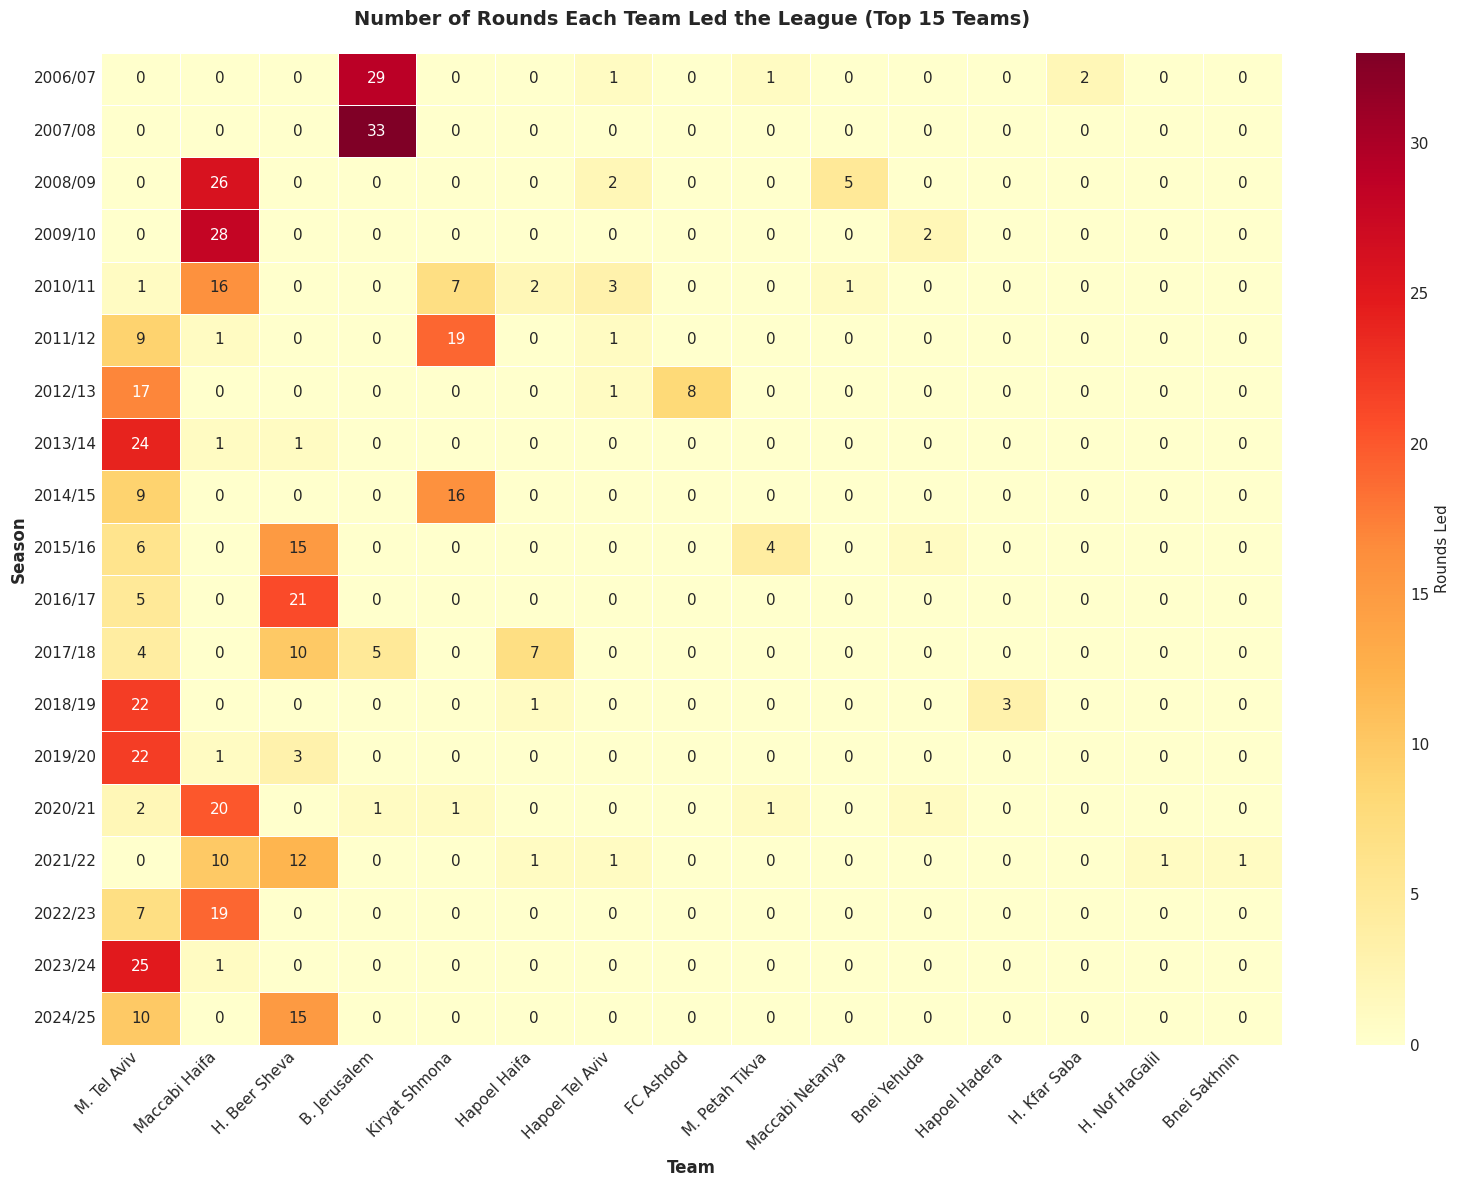


📋 Total Rounds Led Across All Seasons (Top 10):


,Team,Total Rounds Led
0,M. Tel Aviv,163
1,Maccabi Haifa,123
2,H. Beer Sheva,77
3,B. Jerusalem,68
4,Kiryat Shmona,43
5,Hapoel Haifa,11
6,Hapoel Tel Aviv,9
7,FC Ashdod,8
8,M. Petah Tikva,6
9,Maccabi Netanya,6


In [68]:
# Calculate how many rounds each team led in each season
rounds_led = per_round_df.groupby(['season', 'leader']).size().reset_index(name='rounds_led')

# Create pivot table for visualization
rounds_led_pivot = rounds_led.pivot(index='season', columns='leader', values='rounds_led').fillna(0)

# Display top leaders per season
print("📊 Top 3 teams by rounds led per season:\n")
for season in summary_df['season'].head(10):
    season_data = rounds_led[rounds_led['season'] == season].sort_values('rounds_led', ascending=False).head(3)
    print(f"{season}:")
    for _, row in season_data.iterrows():
        print(f"  {row['leader']}: {int(row['rounds_led'])} rounds")
    print()

# Create visualization - heatmap of rounds led
fig, ax = plt.subplots(figsize=(16, 12))

# Select top teams by total rounds led across all seasons
top_teams = rounds_led.groupby('leader')['rounds_led'].sum().sort_values(ascending=False).head(15).index
rounds_led_top = rounds_led[rounds_led['leader'].isin(top_teams)]
rounds_led_pivot_top = rounds_led_top.pivot(index='season', columns='leader', values='rounds_led').fillna(0)

# Sort columns by total rounds led
col_order = rounds_led_pivot_top.sum().sort_values(ascending=False).index
rounds_led_pivot_top = rounds_led_pivot_top[col_order]

sns.heatmap(rounds_led_pivot_top, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Rounds Led'}, linewidths=0.5, ax=ax)
ax.set_title('Number of Rounds Each Team Led the League (Top 15 Teams)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Team', fontsize=12, fontweight='bold')
ax.set_ylabel('Season', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save figure
fig_path = FIG_DIR / 'rounds_led_heatmap.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")

plt.show()

# Summary table - total rounds led by each team across all seasons
total_rounds_led = rounds_led.groupby('leader')['rounds_led'].sum().sort_values(ascending=False).reset_index()
total_rounds_led.columns = ['Team', 'Total Rounds Led']
print("\n📋 Total Rounds Led Across All Seasons (Top 10):")
display(total_rounds_led.head(10))

### 4.3 חילופי הנהגה - כמה פעמים השתנה המובנת

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_changes_per_season_regular.png


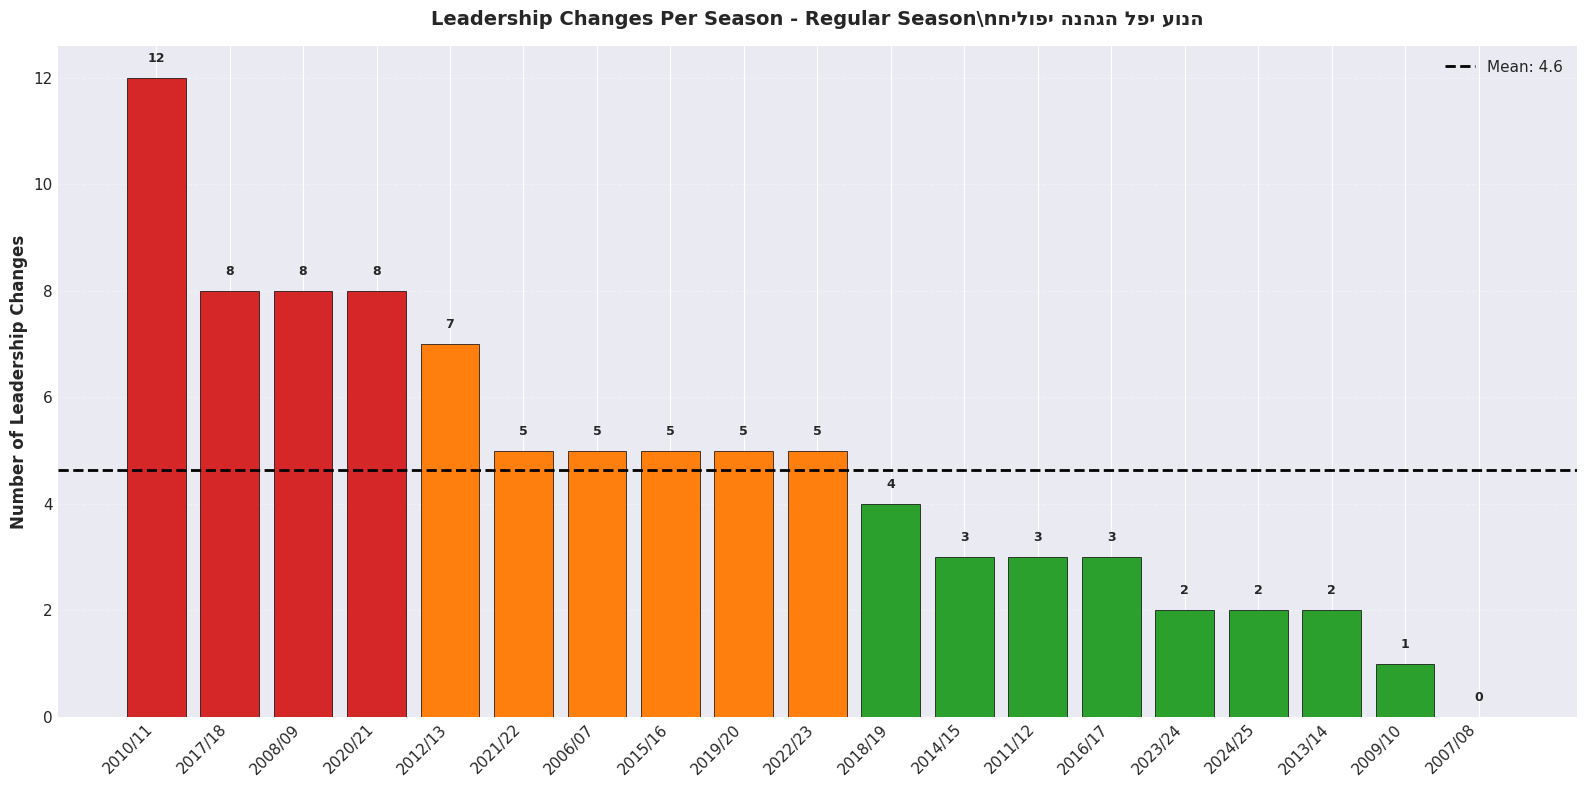


📊 Leadership Changes Statistics:

Mean: 4.63
Median: 5.0
Min: 0
Max: 12
Std Dev: 2.97

🏆 Most Competitive Seasons (Most Changes):


,season,leadership_changes,distinct_leaders,avg_gap
4,2010/11,12,6,1.73
2,2008/09,8,3,2.06
11,2017/18,8,4,0.96
14,2020/21,8,6,2.85
6,2012/13,7,3,3.00



😴 Most Stable Seasons (Fewest Changes):


,season,leadership_changes,distinct_leaders,avg_gap
1,2007/08,0,1,7.94
3,2009/10,1,2,7.57
7,2013/14,2,3,2.96
17,2023/24,2,2,3.19
18,2024/25,2,3,2.15


In [69]:
# Calculate leadership changes per season
summary_df['leadership_changes'] = 0
summary_df['distinct_leaders'] = 0
summary_df['first_leader'] = ''
summary_df['last_leader'] = ''

for season in summary_df['season']:
    season_data = per_round_df[per_round_df['season'] == season].sort_values('round')
    
    # Count leadership changes
    changes = 0
    prev_leader = None
    
    for _, row in season_data.iterrows():
        current_leader = row['leader']
        if prev_leader is not None and current_leader != prev_leader:
            changes += 1
        prev_leader = current_leader
    
    # Count distinct leaders
    distinct = season_data['leader'].nunique()
    
    # Get first and last leader
    first = season_data.iloc[0]['leader']
    last = season_data.iloc[-1]['leader']
    
    # Update summary
    summary_df.loc[summary_df['season'] == season, 'leadership_changes'] = changes
    summary_df.loc[summary_df['season'] == season, 'distinct_leaders'] = distinct
    summary_df.loc[summary_df['season'] == season, 'first_leader'] = first
    summary_df.loc[summary_df['season'] == season, 'last_leader'] = last

# Visualization: Leadership changes per season
fig, ax = plt.subplots(figsize=(16, 8))

summary_sorted = summary_df.sort_values('leadership_changes', ascending=False)
colors = ['#d62728' if x >= 8 else '#ff7f0e' if x >= 5 else '#2ca02c' for x in summary_sorted['leadership_changes']]

ax.bar(range(len(summary_sorted)), summary_sorted['leadership_changes'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(summary_sorted)))
ax.set_xticklabels(summary_sorted['season'], rotation=45, ha='right')
ax.set_ylabel('Number of Leadership Changes', fontsize=12, fontweight='bold')
ax.set_title('Leadership Changes Per Season - Regular Season\\nחילופי הנהגה לפי עונה', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(summary_sorted['leadership_changes'].mean(), color='black', linestyle='--', linewidth=2, 
           label=f"Mean: {summary_sorted['leadership_changes'].mean():.1f}")
ax.legend()

# Add value labels on bars
for i, v in enumerate(summary_sorted['leadership_changes']):
    ax.text(i, v + 0.3, str(int(v)), ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
fig_path = FIG_DIR / 'leadership_changes_per_season_regular.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Summary statistics
print("\n📊 Leadership Changes Statistics:\n")
print(f"Mean: {summary_df['leadership_changes'].mean():.2f}")
print(f"Median: {summary_df['leadership_changes'].median():.1f}")
print(f"Min: {summary_df['leadership_changes'].min():.0f}")
print(f"Max: {summary_df['leadership_changes'].max():.0f}")
print(f"Std Dev: {summary_df['leadership_changes'].std():.2f}")

print("\n🏆 Most Competitive Seasons (Most Changes):")
display(summary_df.nlargest(5, 'leadership_changes')[['season', 'leadership_changes', 'distinct_leaders', 'avg_gap']])

print("\n😴 Most Stable Seasons (Fewest Changes):")
display(summary_df.nsmallest(5, 'leadership_changes')[['season', 'leadership_changes', 'distinct_leaders', 'avg_gap']])

### 4.4 מגוון קבוצות מובילות - כמה קבוצות שונות הובילו בכל עונה

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\distinct_leaders_per_season.png


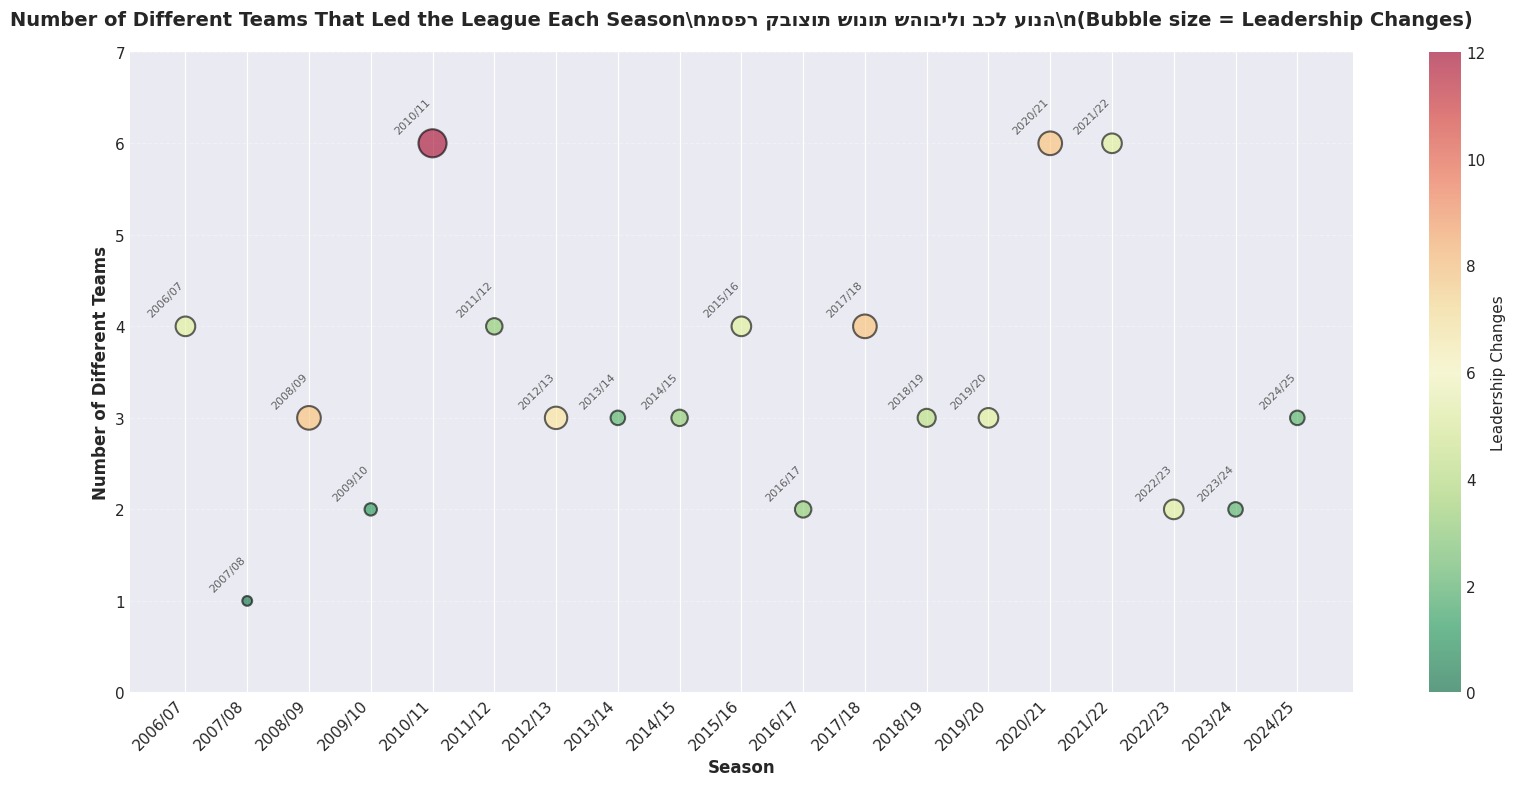


📊 Season Competitiveness Metrics:


,season,leadership_changes,distinct_leaders,first_leader,last_leader,same_leader
0,2006/07,5,4,H. Kfar Saba,B. Jerusalem,False
1,2007/08,0,1,B. Jerusalem,B. Jerusalem,True
2,2008/09,8,3,Maccabi Haifa,Maccabi Haifa,True
3,2009/10,1,2,Bnei Yehuda,Maccabi Haifa,False
4,2010/11,12,6,Maccabi Netanya,Maccabi Haifa,False
5,2011/12,3,4,Maccabi Haifa,Kiryat Shmona,False
6,2012/13,7,3,FC Ashdod,M. Tel Aviv,False
7,2013/14,2,3,Maccabi Haifa,M. Tel Aviv,False
8,2014/15,3,3,Hapoel Raanana,M. Tel Aviv,False
9,2015/16,5,4,Bnei Yehuda,H. Beer Sheva,False



📈 Distribution of Distinct Leaders:
  1 different teams: 1 seasons (5.3%)
  2 different teams: 4 seasons (21.1%)
  3 different teams: 7 seasons (36.8%)
  4 different teams: 4 seasons (21.1%)
  6 different teams: 3 seasons (15.8%)

🎯 Correlation between Leadership Changes and Distinct Leaders:
  Correlation coefficient: 0.692


In [70]:
# Visualization: Distinct leaders per season
fig, ax = plt.subplots(figsize=(16, 8))

# Create scatter plot with size based on leadership changes
scatter = ax.scatter(range(len(summary_df)), summary_df['distinct_leaders'], 
                     s=summary_df['leadership_changes']*30 + 50,
                     c=summary_df['leadership_changes'], cmap='RdYlGn_r',
                     alpha=0.6, edgecolors='black', linewidth=1.5)

# Add season labels
for i, row in summary_df.iterrows():
    ax.text(i, row['distinct_leaders'] + 0.1, row['season'], 
            rotation=45, ha='right', fontsize=8, alpha=0.7)

ax.set_xticks(range(len(summary_df)))
ax.set_xticklabels(summary_df['season'], rotation=45, ha='right')
ax.set_ylabel('Number of Different Teams', fontsize=12, fontweight='bold')
ax.set_xlabel('Season', fontsize=12, fontweight='bold')
ax.set_title('Number of Different Teams That Led the League Each Season\\nמספר קבוצות שונות שהובילו בכל עונה\\n(Bubble size = Leadership Changes)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, summary_df['distinct_leaders'].max() + 1)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Leadership Changes')

plt.tight_layout()
fig_path = FIG_DIR / 'distinct_leaders_per_season.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Create combined table
combined_metrics = summary_df[['season', 'leadership_changes', 'distinct_leaders', 'first_leader', 'last_leader']].copy()
combined_metrics['same_leader'] = combined_metrics['first_leader'] == combined_metrics['last_leader']

print("\n📊 Season Competitiveness Metrics:")
display(combined_metrics)

# Distribution analysis
print("\n📈 Distribution of Distinct Leaders:")
distinct_distribution = summary_df['distinct_leaders'].value_counts().sort_index()
for leaders, count in distinct_distribution.items():
    pct = (count / len(summary_df)) * 100
    print(f"  {int(leaders)} different teams: {count} seasons ({pct:.1f}%)")

print("\n🎯 Correlation between Leadership Changes and Distinct Leaders:")
corr = summary_df[['leadership_changes', 'distinct_leaders']].corr()
print(f"  Correlation coefficient: {corr.iloc[0, 1]:.3f}")

### 4.5 אחוז חילופי הנהגה - תדירות השינויים

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_change_percentage.png


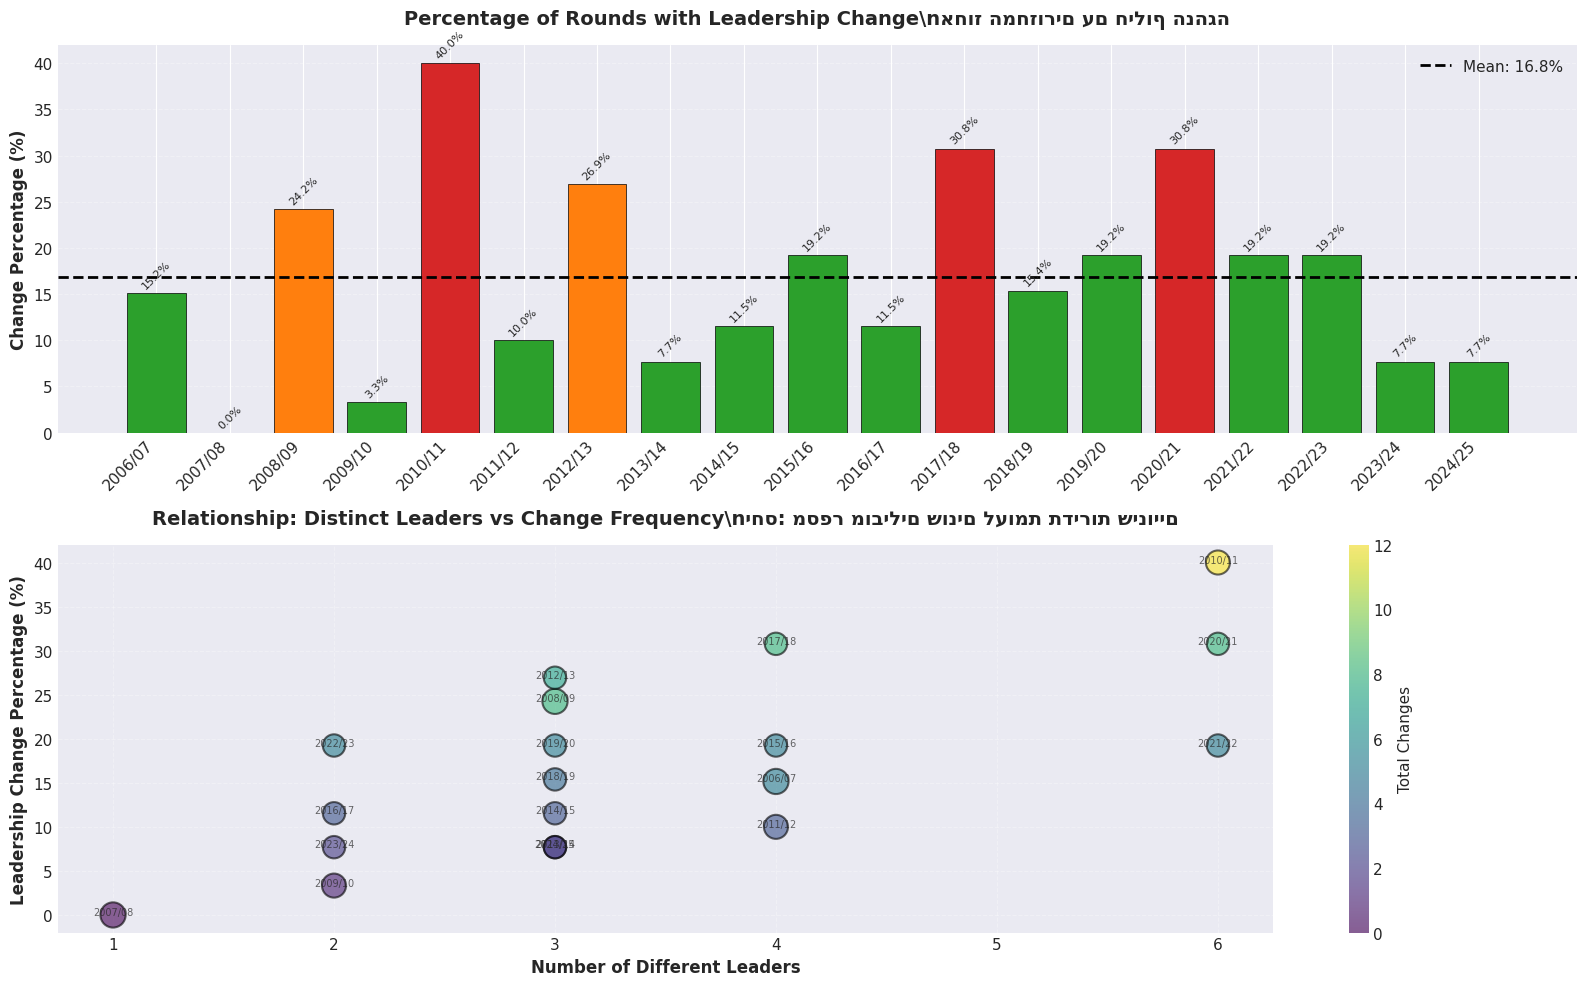


📊 Seasons by Leadership Change Frequency:

Most Dynamic (highest change %):


,season,leadership_changes,rounds,change_percentage,distinct_leaders
4,2010/11,12,30,40.000000,6
11,2017/18,8,26,30.769231,4
14,2020/21,8,26,30.769231,6
6,2012/13,7,26,26.923077,3
2,2008/09,8,33,24.242424,3



Most Stable (lowest change %):


,season,leadership_changes,rounds,change_percentage,distinct_leaders
17,2023/24,2,26,7.692308,2
18,2024/25,2,26,7.692308,3
7,2013/14,2,26,7.692308,3
3,2009/10,1,30,3.333333,2
1,2007/08,0,33,0.000000,1



📈 Overall Statistics:
  Mean change percentage: 16.82%
  Median change percentage: 15.38%
  Std deviation: 10.35%
  Range: 0.00% - 40.00%


In [71]:
# Calculate percentage of rounds with leadership change
summary_df['change_percentage'] = (summary_df['leadership_changes'] / summary_df['rounds']) * 100

# Visualization: Change percentage per season
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Bar chart
ax1 = axes[0]
colors2 = ['#d62728' if x >= 30 else '#ff7f0e' if x >= 20 else '#2ca02c' for x in summary_df['change_percentage']]
ax1.bar(range(len(summary_df)), summary_df['change_percentage'], color=colors2, edgecolor='black', linewidth=0.5)
ax1.set_xticks(range(len(summary_df)))
ax1.set_xticklabels(summary_df['season'], rotation=45, ha='right')
ax1.set_ylabel('Change Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_title('Percentage of Rounds with Leadership Change\\nאחוז המחזורים עם חילוף הנהגה', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(summary_df['change_percentage'].mean(), color='black', linestyle='--', linewidth=2, 
            label=f"Mean: {summary_df['change_percentage'].mean():.1f}%")
ax1.legend()

# Add value labels
for i, v in enumerate(summary_df['change_percentage']):
    ax1.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=8, rotation=45)

# Scatter plot: Change % vs Distinct Leaders
ax2 = axes[1]
scatter = ax2.scatter(summary_df['distinct_leaders'], summary_df['change_percentage'],
                     s=summary_df['rounds']*10, alpha=0.6, 
                     c=summary_df['leadership_changes'], cmap='viridis',
                     edgecolors='black', linewidth=1.5)

# Add season labels
for _, row in summary_df.iterrows():
    ax2.annotate(row['season'], (row['distinct_leaders'], row['change_percentage']),
                fontsize=7, alpha=0.7, ha='center')

ax2.set_xlabel('Number of Different Leaders', fontsize=12, fontweight='bold')
ax2.set_ylabel('Leadership Change Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Relationship: Distinct Leaders vs Change Frequency\\nיחס: מספר מובילים שונים לעומת תדירות שינויים', 
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, linestyle='--')
cbar = plt.colorbar(scatter, ax=ax2, label='Total Changes')

plt.tight_layout()
fig_path = FIG_DIR / 'leadership_change_percentage.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Summary table with percentages
summary_with_pct = summary_df[['season', 'leadership_changes', 'rounds', 'change_percentage', 'distinct_leaders']].copy()
summary_with_pct = summary_with_pct.sort_values('change_percentage', ascending=False)

print("\n📊 Seasons by Leadership Change Frequency:\n")
print("Most Dynamic (highest change %):")
display(summary_with_pct.head(5))

print("\nMost Stable (lowest change %):")
display(summary_with_pct.tail(5))

print("\n📈 Overall Statistics:")
print(f"  Mean change percentage: {summary_df['change_percentage'].mean():.2f}%")
print(f"  Median change percentage: {summary_df['change_percentage'].median():.2f}%")
print(f"  Std deviation: {summary_df['change_percentage'].std():.2f}%")
print(f"  Range: {summary_df['change_percentage'].min():.2f}% - {summary_df['change_percentage'].max():.2f}%")

### 4.6 ניתוח פער נקודות - סיכום מקיף לכל העונות

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\points_gap_all_seasons_summary.png


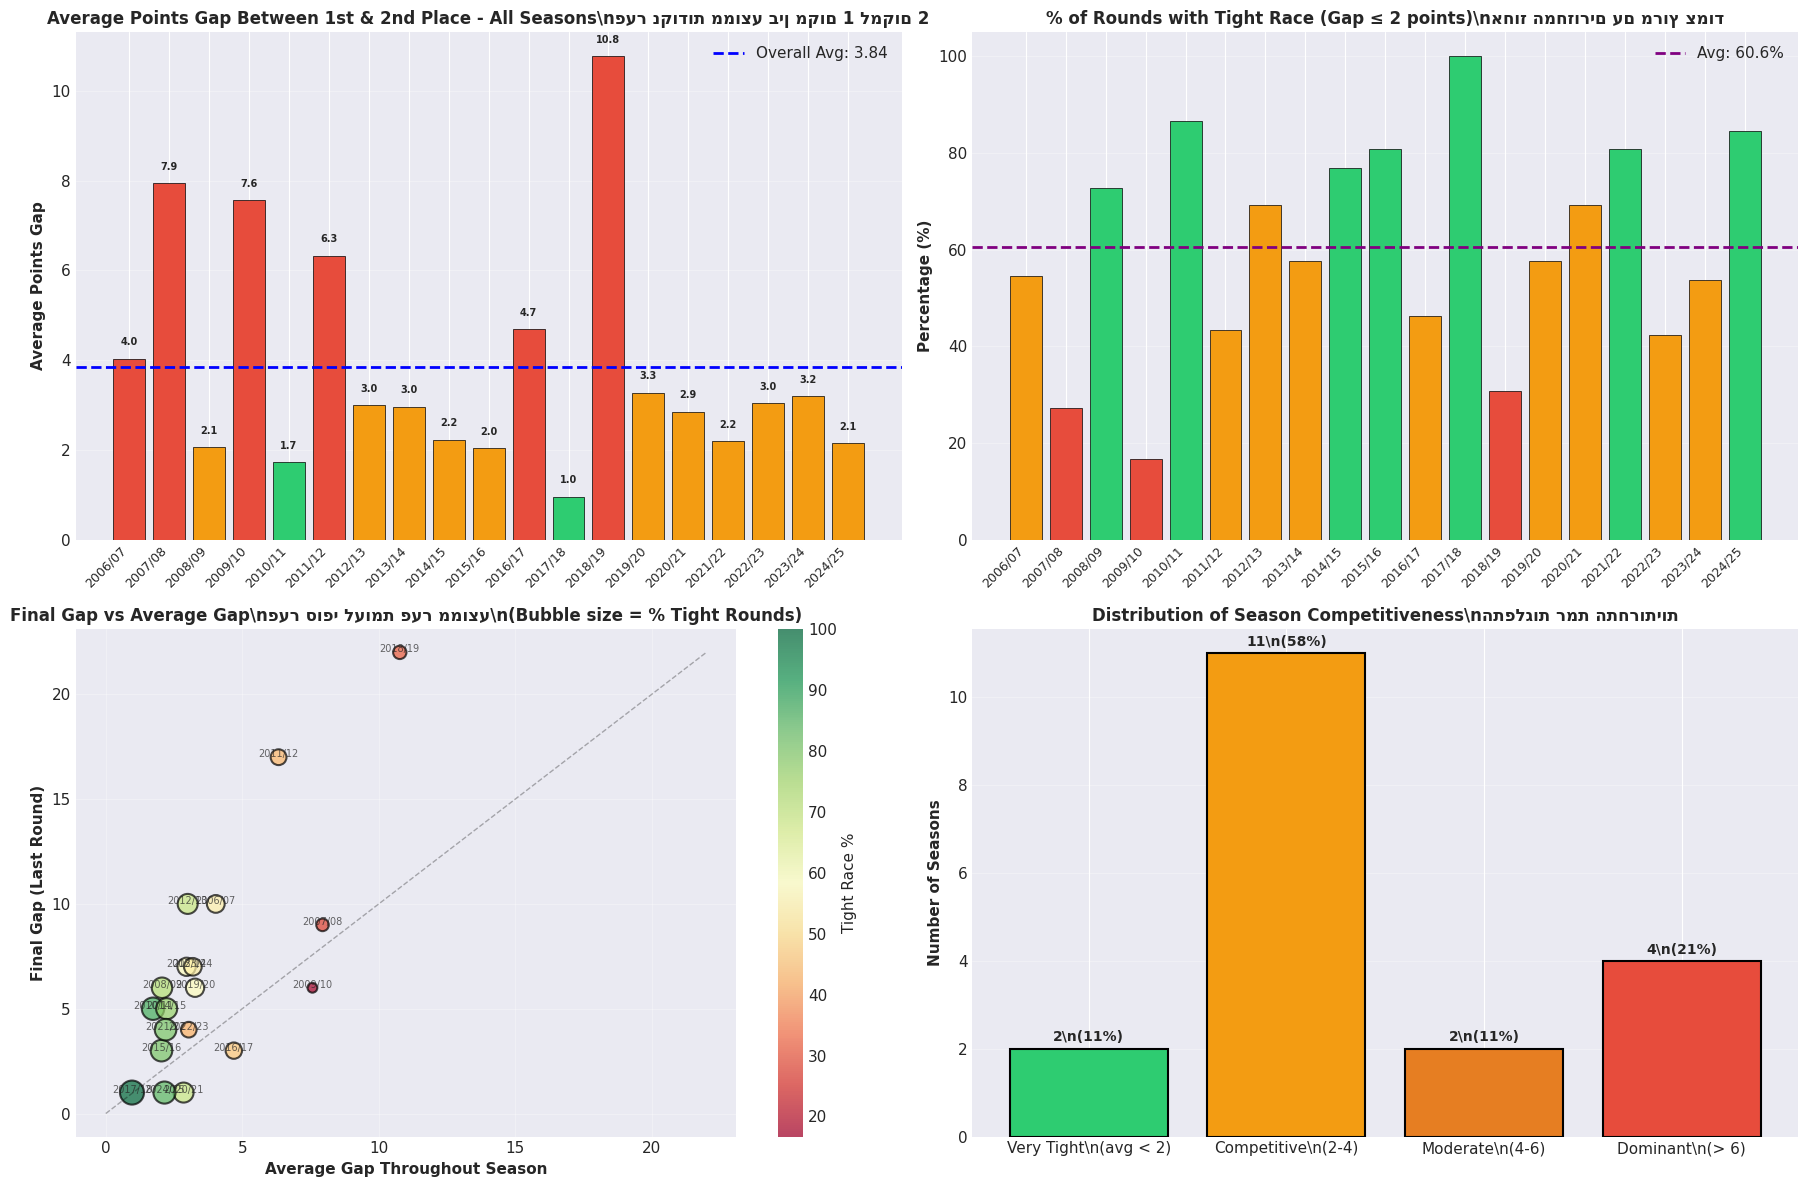


📊 POINTS GAP ANALYSIS - SUMMARY STATISTICS

📈 Overall Statistics:
   Total seasons analyzed: 19
   Average gap (overall): 3.84 points
   Most competitive season: 2017/18 (0.96 pts)
   Least competitive season: 2018/19 (10.77 pts)

🎯 Tight Race Analysis:
   Average tight race %: 60.6%
   Seasons with >50% tight rounds: 13
   Seasons with <20% tight rounds: 1


In [72]:
# Use the existing all_scraped_gaps_df data that we already have!
# This is much better than recalculating - it's the actual Transfermarkt scraped data

# Create comprehensive visualization of points gap across all seasons
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Average Gap per Season
ax1 = axes[0, 0]
colors = ['#2ecc71' if x < 2 else '#f39c12' if x < 4 else '#e74c3c' 
          for x in stats_df['avg_gap']]
bars1 = ax1.bar(range(len(stats_df)), stats_df['avg_gap'], 
               color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xticks(range(len(stats_df)))
ax1.set_xticklabels(stats_df['season'], rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Average Points Gap', fontsize=11, fontweight='bold')
ax1.set_title('Average Points Gap Between 1st & 2nd Place - All Seasons\\nפער נקודות ממוצע בין מקום 1 למקום 2', 
              fontsize=12, fontweight='bold')
ax1.axhline(stats_df['avg_gap'].mean(), color='blue', linestyle='--', 
            linewidth=2, label=f'Overall Avg: {stats_df["avg_gap"].mean():.2f}')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Add value labels on bars
for i, (idx, row) in enumerate(stats_df.iterrows()):
    ax1.text(i, row['avg_gap'] + 0.3, f"{row['avg_gap']:.1f}", 
            ha='center', fontsize=7, fontweight='bold')

# 2. Tight Race Percentage
ax2 = axes[0, 1]
colors2 = ['#2ecc71' if x > 70 else '#f39c12' if x > 40 else '#e74c3c' 
           for x in stats_df['tight_pct']]
bars2 = ax2.bar(range(len(stats_df)), stats_df['tight_pct'], 
        color=colors2, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(stats_df)))
ax2.set_xticklabels(stats_df['season'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('% of Rounds with Tight Race (Gap ≤ 2 points)\\nאחוז המחזורים עם מרוץ צמוד', 
              fontsize=12, fontweight='bold')
ax2.axhline(stats_df['tight_pct'].mean(), color='purple', linestyle='--', 
            linewidth=2, label=f'Avg: {stats_df["tight_pct"].mean():.1f}%')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

# 3. Final Gap vs Average Gap
ax3 = axes[1, 0]
scatter = ax3.scatter(stats_df['avg_gap'], stats_df['final_gap'], 
                     s=stats_df['tight_pct']*3, 
                     c=stats_df['tight_pct'], cmap='RdYlGn',
                     alpha=0.7, edgecolors='black', linewidth=1.5)
for _, row in stats_df.iterrows():
    ax3.annotate(row['season'], (row['avg_gap'], row['final_gap']),
                fontsize=7, alpha=0.7, ha='center')
ax3.set_xlabel('Average Gap Throughout Season', fontsize=11, fontweight='bold')
ax3.set_ylabel('Final Gap (Last Round)', fontsize=11, fontweight='bold')
ax3.set_title('Final Gap vs Average Gap\\nפער סופי לעומת פער ממוצע\\n(Bubble size = % Tight Rounds)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3, label='Tight Race %')

# Add diagonal line (where final = average)
max_val = max(stats_df['avg_gap'].max(), stats_df['final_gap'].max())
ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1)

# 4. Distribution of Race Competitiveness
ax4 = axes[1, 1]
categories = ['Very Tight\\n(avg < 2)', 'Competitive\\n(2-4)', 
              'Moderate\\n(4-6)', 'Dominant\\n(> 6)']
counts = [
    (stats_df['avg_gap'] < 2).sum(),
    ((stats_df['avg_gap'] >= 2) & (stats_df['avg_gap'] < 4)).sum(),
    ((stats_df['avg_gap'] >= 4) & (stats_df['avg_gap'] < 6)).sum(),
    (stats_df['avg_gap'] >= 6).sum()
]
colors4 = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
bars4 = ax4.bar(categories, counts, color=colors4, edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Number of Seasons', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of Season Competitiveness\\nהתפלגות רמת התחרותיות', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, count) in enumerate(zip(bars4, counts)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{count}\\n({count/len(stats_df)*100:.0f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
fig_path = FIG_DIR / 'points_gap_all_seasons_summary.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("📊 POINTS GAP ANALYSIS - SUMMARY STATISTICS")
print("="*80)
print(f"\n📈 Overall Statistics:")
print(f"   Total seasons analyzed: {len(stats_df)}")
print(f"   Average gap (overall): {stats_df['avg_gap'].mean():.2f} points")
print(f"   Most competitive season: {stats_df.loc[stats_df['avg_gap'].idxmin(), 'season']} ({stats_df['avg_gap'].min():.2f} pts)")
print(f"   Least competitive season: {stats_df.loc[stats_df['avg_gap'].idxmax(), 'season']} ({stats_df['avg_gap'].max():.2f} pts)")
print(f"\n🎯 Tight Race Analysis:")
print(f"   Average tight race %: {stats_df['tight_pct'].mean():.1f}%")
print(f"   Seasons with >50% tight rounds: {(stats_df['tight_pct'] > 50).sum()}")
print(f"   Seasons with <20% tight rounds: {(stats_df['tight_pct'] < 20).sum()}")

## 5. Regular Season Visualizations
### גרפים - ניתוח החרוץ האליפות בעונה הרגילה

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\seasons_avg_gap_comparison.png


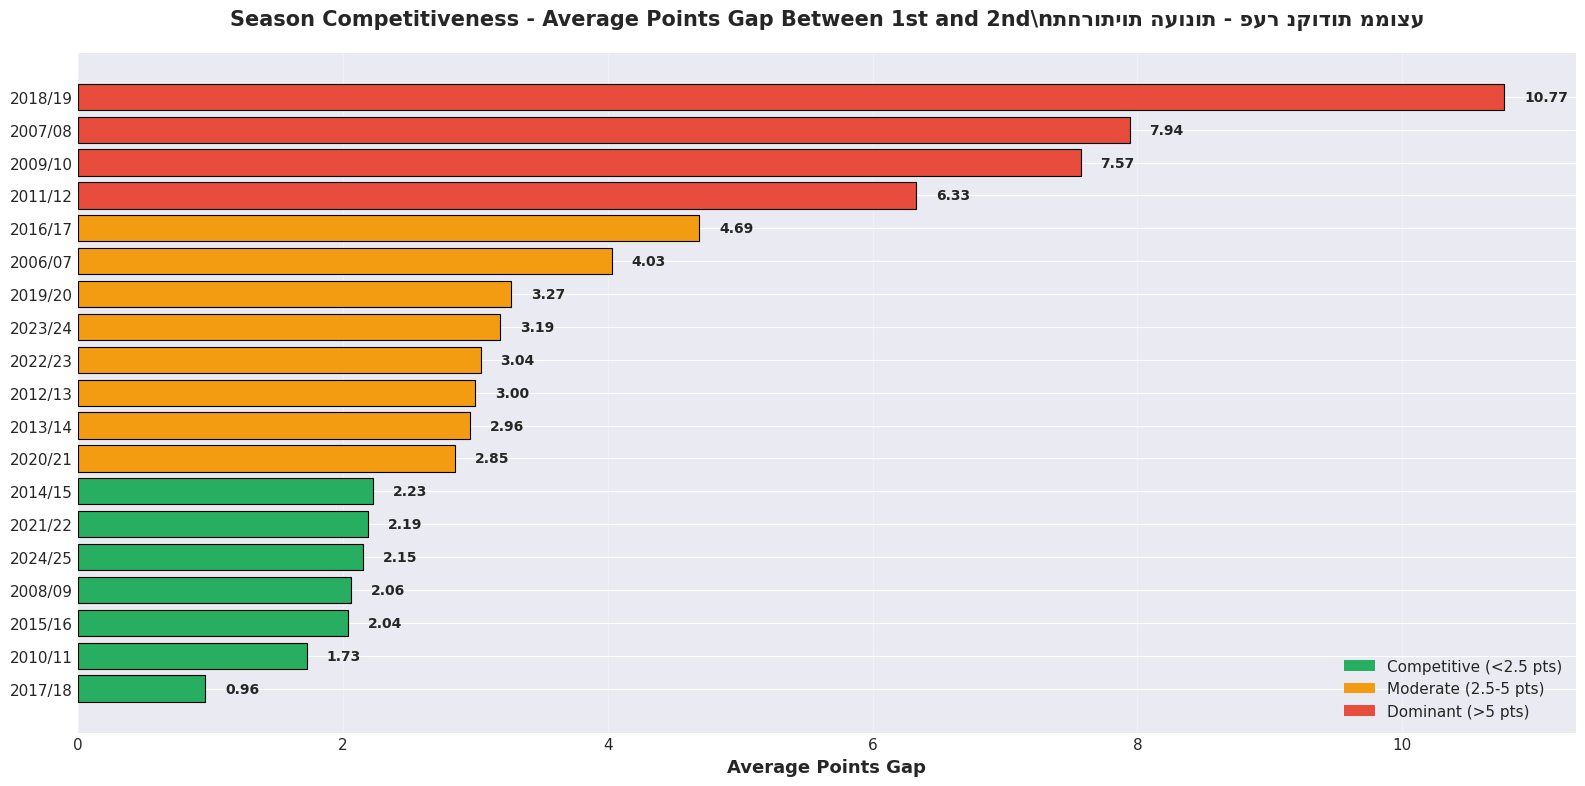

In [73]:
# Visualization 2: Compare all seasons - Average gap
fig, ax = plt.subplots(figsize=(16, 8))

# Sort by average gap
stats_sorted = stats_df.sort_values('avg_gap')

# Color code: green (competitive) to red (dominant)
colors = ['#27ae60' if x < 2.5 else '#f39c12' if x < 5 else '#e74c3c' for x in stats_sorted['avg_gap']]

bars = ax.barh(range(len(stats_sorted)), stats_sorted['avg_gap'], color=colors, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(stats_sorted)))
ax.set_yticklabels(stats_sorted['season'])
ax.set_xlabel('Average Points Gap', fontsize=13, fontweight='bold')
ax.set_title('Season Competitiveness - Average Points Gap Between 1st and 2nd\\nתחרותיות העונות - פער נקודות ממוצע', 
             fontsize=15, fontweight='bold', pad=20)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, stats_sorted['avg_gap'])):
    ax.text(val + 0.15, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
            va='center', fontsize=10, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='Competitive (<2.5 pts)'),
    Patch(facecolor='#f39c12', label='Moderate (2.5-5 pts)'),
    Patch(facecolor='#e74c3c', label='Dominant (>5 pts)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()

fig_path = FIG_DIR / 'seasons_avg_gap_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")

plt.show()

In [74]:
# Team name mapping: BetExplorer (playoff files) → Transfermarkt (regular season)
BETEXPLORER_TO_TM = {
    "Beitar Jerusalem": "B. Jerusalem",
    "Hapoel Beer Sheva": "Hapoel Be'er Sheva",
    "Hapoel Haifa": "Hapoel Haifa",
    "Hapoel Tel Aviv": "Hapoel Tel Aviv",
    "Maccabi Haifa": "Maccabi Haifa",
    "Maccabi Netanya": "Maccabi Netanya",
    "Maccabi Petah Tikva": "M. Petah Tikva",
    "Maccabi Tel Aviv": "M. Tel Aviv",
    "Hapoel Ramat Gan": "Hapoel Ramat Gan",
    "Ironi Kiryat Shmona": "Kiryat Shmona",
    "Bnei Yehuda Tel Aviv": "Bnei Yehuda",
    "Bnei Sakhnin": "Bnei Sachnin",
    "Hapoel Hadera": "Hapoel Hadera",
    "Ashdod": "FC Ashdod",
    "Hapoel Kfar Saba": "H. Kfar Saba",
    "Ironi Ramat HaSharon": "Ramat haSharon",
    "Hapoel Acre": "Hapoel Acre"
}

def map_team_name(betexplorer_name):
    """Map BetExplorer team name to Transfermarkt name"""
    return BETEXPLORER_TO_TM.get(betexplorer_name, betexplorer_name)

print("✅ Team name mapping created!")

✅ Team name mapping created!


In [75]:
def calculate_playoff_gaps(season_str):
    """
    Calculate playoff gaps with correct point transfer from regular season
    
    Handles two playoff formats:
    1. 2009/10-2011/12: Points divided (halved or reduced)
    2. 2012/13-2024/25: Full points transferred
    
    Args:
        season_str: Season like "2017/18"
    
    Returns:
        DataFrame with playoff gap data, or None if no playoff
    """
    # Check if playoff file exists in scraped_betexplorer directory
    # Format: championship_2017_18.csv (not 2017_2018)
    playoff_file = PLAYOFF_DIR / 'scraped_betexplorer' / f'championship_{season_str.replace("/", "_")}.csv'
    
    if not playoff_file.exists():
        print(f"  ⚠️ Playoff file not found: {playoff_file}")
        return None
    
    # Load playoff matches
    playoff_df = pd.read_csv(playoff_file)
    
    if len(playoff_df) == 0:
        return None
    
    # Get regular season final standings
    regular_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season_str]
    
    if len(regular_data) == 0:
        print(f"  ⚠️ No regular season data for {season_str}")
        return None
    
    # Get final round standings
    final_round = regular_data['round'].max()
    
    # Get all unique teams in playoff
    playoff_teams = set(playoff_df['home_team'].unique()) | set(playoff_df['away_team'].unique())
    
    # Map team names from BetExplorer to Transfermarkt
    playoff_teams_mapped = {map_team_name(team) for team in playoff_teams}
    
    # Initialize points from regular season
    starting_points = {}
    
    # Determine format based on season
    year = int(season_str.split('/')[0])
    
    # קיזוז היה רק ב-2009/10 ו-2010/11
    if season_str in ['2009/10', '2010/11']:  # Only these two seasons had point reduction
        # For these seasons, points were halved or divided
        # Get top 6 teams from regular season
        # We'll use the actual scraped standings to get the correct points
        
        # Get all teams' points from final round by scraping
        final_round_standings = scrape_transfermarkt_standings(season_str, final_round)
        
        if final_round_standings is not None:
            # Top 6 teams went to championship playoff
            top6 = final_round_standings.head(6)
            
            for _, row in top6.iterrows():
                team = row['team']
                # Points were halved (rounded down)
                starting_points[team] = row['points'] // 2
        
        print(f"  📊 {season_str} (קיזוז): Starting points halved")
    
    else:  # All other seasons: Full points transferred
        # Get all teams' final points
        final_round_standings = scrape_transfermarkt_standings(season_str, final_round)
        
        if final_round_standings is not None:
            # Top 6 teams went to championship playoff  
            top6 = final_round_standings.head(6)
            
            for _, row in top6.iterrows():
                team = row['team']
                # Full points transferred
                starting_points[team] = row['points']
        
        print(f"  📊 {season_str} (נקודות מלאות): Full points transferred")
    
    if not starting_points:
        print(f"  ❌ Could not get starting points for {season_str}")
        return None
    
    # Calculate points after each playoff round
    # Group playoff matches by round
    playoff_df_sorted = playoff_df.sort_values('round')
    
    # Create standings dictionary
    standings = starting_points.copy()
    
    gaps_data = []
    
    for round_num in sorted(playoff_df_sorted['round'].unique()):
        round_matches = playoff_df_sorted[playoff_df_sorted['round'] == round_num]
        
        # Process each match
        for _, match in round_matches.iterrows():
            home_team = map_team_name(match['home_team'])
            away_team = map_team_name(match['away_team'])
            home_score = match['home_goals']
            away_score = match['away_goals']
            
            # Award points
            if home_score > away_score:
                standings[home_team] = standings.get(home_team, 0) + 3
            elif away_score > home_score:
                standings[away_team] = standings.get(away_team, 0) + 3
            else:  # Draw
                standings[home_team] = standings.get(home_team, 0) + 1
                standings[away_team] = standings.get(away_team, 0) + 1
        
        # Get top 2
        sorted_teams = sorted(standings.items(), key=lambda x: x[1], reverse=True)
        
        if len(sorted_teams) >= 2:
            leader, leader_pts = sorted_teams[0]
            second, second_pts = sorted_teams[1]
            gap = leader_pts - second_pts
            
            gaps_data.append({
                'season': season_str,
                'round': round_num,
                'leader': leader,
                'leader_points': leader_pts,
                'second': second,
                'second_points': second_pts,
                'gap': gap
            })
    
    if not gaps_data:
        return None
    
    df = pd.DataFrame(gaps_data)
    print(f"  ✅ Collected {len(df)} playoff rounds")
    
    return df

print("✅ Playoff calculation function created!")

✅ Playoff calculation function created!


In [76]:
# Calculate playoff gaps for all seasons
print("="*80)
print("🏆 CALCULATING PLAYOFF GAPS")
print("="*80)
print()

all_playoff_gaps = []

# Seasons with playoffs
playoff_seasons = [s for s in all_scraped_gaps_df['season'].unique() if int(s.split('/')[0]) >= 2009]

print(f"Processing {len(playoff_seasons)} seasons with playoffs...\\n")

for season in playoff_seasons:
    print(f"Processing {season}...")
    playoff_gap_df = calculate_playoff_gaps(season)
    
    if playoff_gap_df is not None:
        all_playoff_gaps.append(playoff_gap_df)
    else:
        print(f"  ⚠️ No playoff data for {season}")
    print()

if all_playoff_gaps:
    all_playoff_gaps_df = pd.concat(all_playoff_gaps, ignore_index=True)
    
    print("="*80)
    print(f"✅ PLAYOFF CALCULATION COMPLETED")
    print("="*80)
    print()
    print(f"📊 Playoff data collected:")
    print(f"   Seasons: {all_playoff_gaps_df['season'].nunique()}")
    print(f"   Total playoff rounds: {len(all_playoff_gaps_df)}")
    print()
    
    # Show summary
    print("📋 Playoff rounds per season:")
    for season in sorted(all_playoff_gaps_df['season'].unique()):
        count = len(all_playoff_gaps_df[all_playoff_gaps_df['season'] == season])
        print(f"   {season}: {count} rounds")
else:
    print("❌ No playoff data collected")
    all_playoff_gaps_df = None

🏆 CALCULATING PLAYOFF GAPS

Processing 16 seasons with playoffs...\n
Processing 2009/10...
  📊 2009/10 (קיזוז): Starting points halved
  ✅ Collected 5 playoff rounds

Processing 2010/11...
  📊 2009/10 (קיזוז): Starting points halved
  ✅ Collected 5 playoff rounds

Processing 2010/11...
  📊 2010/11 (קיזוז): Starting points halved
  ✅ Collected 5 playoff rounds

Processing 2011/12...
  📊 2010/11 (קיזוז): Starting points halved
  ✅ Collected 5 playoff rounds

Processing 2011/12...
  📊 2011/12 (נקודות מלאות): Full points transferred
  ✅ Collected 7 playoff rounds

Processing 2012/13...
  📊 2011/12 (נקודות מלאות): Full points transferred
  ✅ Collected 7 playoff rounds

Processing 2012/13...
  ⚠️ Error scraping 2012/13 round 26: HTTPSConnectionPool(host='www.transfermarkt.com', port=443): Read timed out. (read timeout=10)
  📊 2012/13 (נקודות מלאות): Full points transferred
  ❌ Could not get starting points for 2012/13
  ⚠️ No playoff data for 2012/13

Processing 2013/14...
  ⚠️ Error scrapin

In [77]:
# Compare regular season vs playoff gaps
if all_playoff_gaps_df is not None:
    comparison_data = []
    
    for season in all_playoff_gaps_df['season'].unique():
        # Regular season final gap
        reg_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season]
        reg_final_gap = reg_data.iloc[-1]['gap']
        reg_avg_gap = reg_data['gap'].mean()
        
        # Playoff final gap
        playoff_data = all_playoff_gaps_df[all_playoff_gaps_df['season'] == season]
        playoff_final_gap = playoff_data.iloc[-1]['gap']
        playoff_avg_gap = playoff_data['gap'].mean()
        
        # Determine outcome
        if playoff_final_gap > reg_final_gap:
            outcome = "Gap increased"
        elif playoff_final_gap < reg_final_gap:
            outcome = "Gap decreased"
        else:
            outcome = "Gap stayed same"
        
        comparison_data.append({
            'season': season,
            'reg_final_gap': reg_final_gap,
            'playoff_final_gap': playoff_final_gap,
            'gap_change': playoff_final_gap - reg_final_gap,
            'reg_avg_gap': round(reg_avg_gap, 2),
            'playoff_avg_gap': round(playoff_avg_gap, 2),
            'outcome': outcome
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("="*80)
    print("📊 REGULAR SEASON vs PLAYOFF COMPARISON")
    print("="*80)
    print()
    print(comparison_df.to_string(index=False))
    print()
    print("="*80)
    print("📈 Summary:")
    print("="*80)
    print(f"Gap increased in playoffs: {len(comparison_df[comparison_df['gap_change'] > 0])} seasons")
    print(f"Gap decreased in playoffs: {len(comparison_df[comparison_df['gap_change'] < 0])} seasons")
    print(f"Gap stayed same: {len(comparison_df[comparison_df['gap_change'] == 0])} seasons")
    print()
    print(f"Average gap change: {comparison_df['gap_change'].mean():.2f} points")
else:
    print("⚠️ No playoff data available for comparison")
    comparison_df = None

📊 REGULAR SEASON vs PLAYOFF COMPARISON

 season  reg_final_gap  playoff_final_gap  gap_change  reg_avg_gap  playoff_avg_gap       outcome
2009/10              6                  0          -6         7.57             1.00 Gap decreased
2010/11              5                  8           3         1.73             4.60 Gap increased
2011/12             17                 14          -3         6.33            15.14 Gap decreased
2014/15              5                  6           1         2.23             7.60 Gap increased
2015/16              3                  2          -1         2.04             2.00 Gap decreased
2016/17              3                 13          10         4.69             8.00 Gap increased
2017/18              1                  9           8         0.96             5.70 Gap increased
2018/19             22                 31           9        10.77            28.70 Gap increased
2019/20              6                 14           8         3.27            

### 6.1 ניתוח חילופי הנהגה בפלייאוף

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\leadership_changes_regular_vs_playoff.png


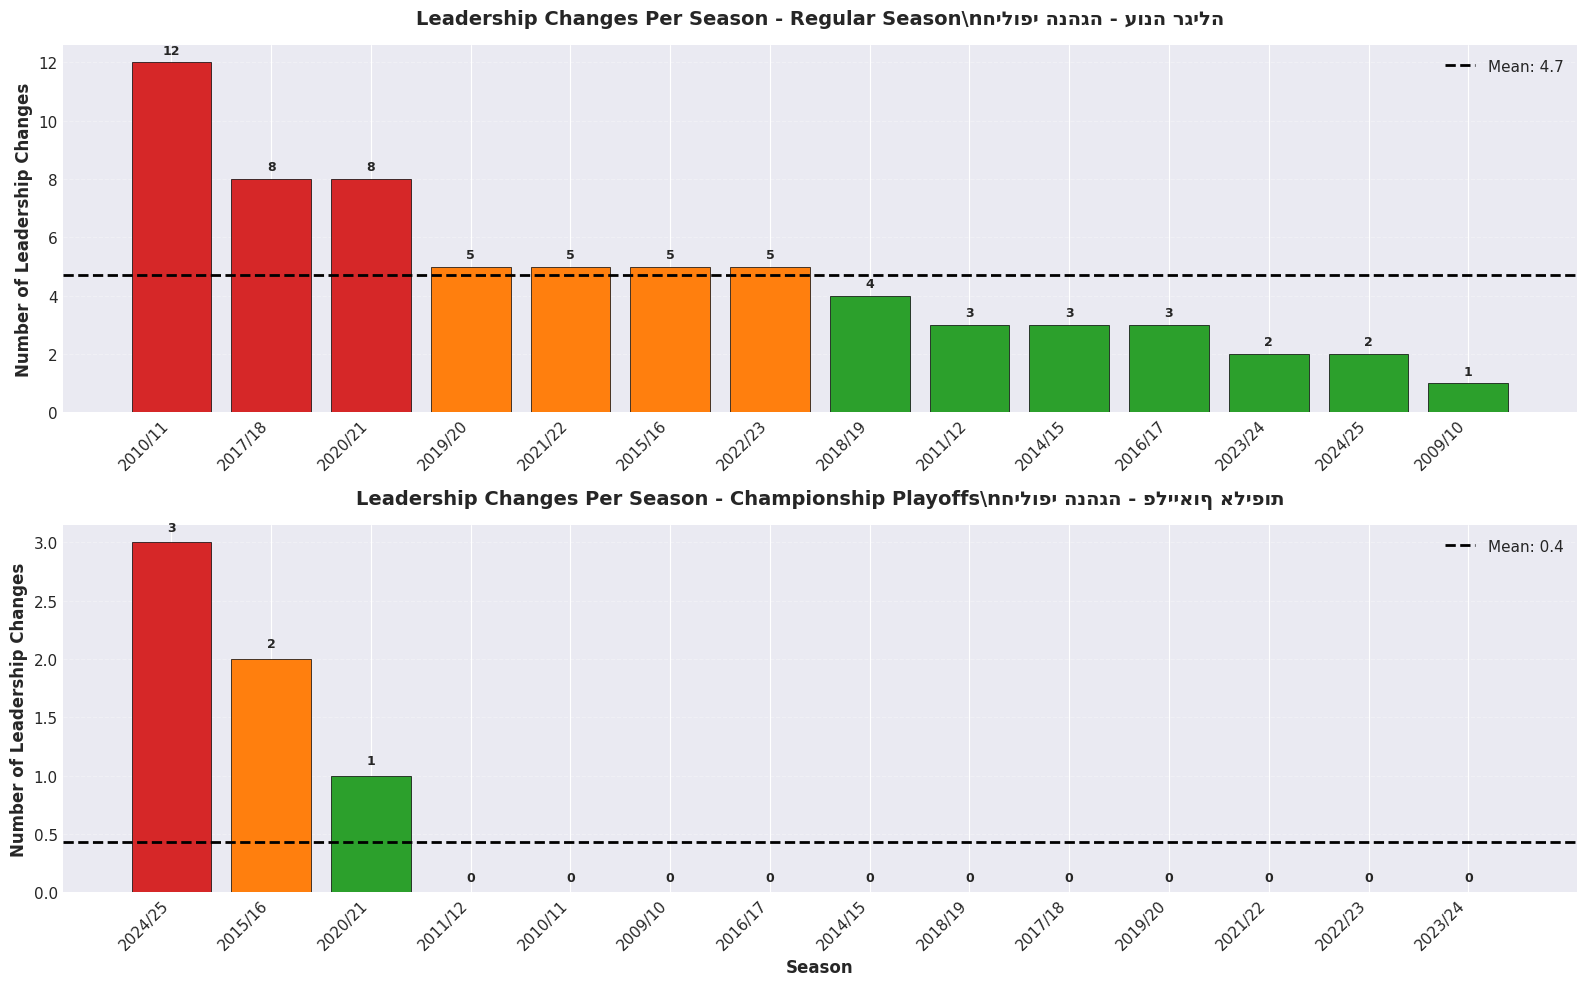


📊 Leadership Changes Statistics:



,Phase,Mean,Median,Min,Max,Std Dev
0,Regular Season,4.714286,4.5,1,12,2.946408
1,Championship Playoffs,0.428571,0.0,0,3,0.937614



🏆 Most Competitive Playoff Seasons:


,season,playoff_leadership_changes,playoff_distinct_leaders
13,2024/25,3,2
4,2015/16,2,2
9,2020/21,1,2
0,2009/10,0,1
1,2010/11,0,1



😴 Most Stable Playoff Seasons:


,season,playoff_leadership_changes,playoff_distinct_leaders
0,2009/10,0,1
1,2010/11,0,1
2,2011/12,0,1
3,2014/15,0,1
5,2016/17,0,1


In [78]:
# Calculate leadership changes for playoffs
if all_playoff_gaps_df is not None:
    playoff_summary_data = []
    
    for season in all_playoff_gaps_df['season'].unique():
        season_data = all_playoff_gaps_df[all_playoff_gaps_df['season'] == season].sort_values('round')
        
        # Count leadership changes
        changes = 0
        prev_leader = None
        
        for _, row in season_data.iterrows():
            current_leader = row['leader']
            if prev_leader is not None and current_leader != prev_leader:
                changes += 1
            prev_leader = current_leader
        
        # Count distinct leaders
        distinct = season_data['leader'].nunique()
        
        # Get first and last leader
        first = season_data.iloc[0]['leader']
        last = season_data.iloc[-1]['leader']
        
        playoff_summary_data.append({
            'season': season,
            'playoff_leadership_changes': changes,
            'playoff_distinct_leaders': distinct,
            'playoff_first_leader': first,
            'playoff_last_leader': last,
            'playoff_rounds': len(season_data)
        })
    
    playoff_summary_df = pd.DataFrame(playoff_summary_data)
    
    # Visualization: Compare regular season vs playoff leadership changes
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Regular season (from summary_df)
    ax1 = axes[0]
    summary_sorted = summary_df[summary_df['season'].isin(playoff_summary_df['season'])].sort_values('leadership_changes', ascending=False)
    colors = ['#d62728' if x >= 8 else '#ff7f0e' if x >= 5 else '#2ca02c' for x in summary_sorted['leadership_changes']]
    
    ax1.bar(range(len(summary_sorted)), summary_sorted['leadership_changes'], color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_xticks(range(len(summary_sorted)))
    ax1.set_xticklabels(summary_sorted['season'], rotation=45, ha='right')
    ax1.set_ylabel('Number of Leadership Changes', fontsize=12, fontweight='bold')
    ax1.set_title('Leadership Changes Per Season - Regular Season\\nחילופי הנהגה - עונה רגילה', fontsize=14, fontweight='bold', pad=15)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.axhline(summary_sorted['leadership_changes'].mean(), color='black', linestyle='--', linewidth=2, 
               label=f"Mean: {summary_sorted['leadership_changes'].mean():.1f}")
    ax1.legend()
    
    # Add value labels on bars
    for i, v in enumerate(summary_sorted['leadership_changes']):
        ax1.text(i, v + 0.3, str(int(v)), ha='center', fontsize=9, fontweight='bold')
    
    # Playoff comparison
    ax2 = axes[1]
    playoff_sorted = playoff_summary_df.sort_values('playoff_leadership_changes', ascending=False)
    colors_playoff = ['#d62728' if x >= 3 else '#ff7f0e' if x >= 2 else '#2ca02c' for x in playoff_sorted['playoff_leadership_changes']]
    
    ax2.bar(range(len(playoff_sorted)), playoff_sorted['playoff_leadership_changes'], color=colors_playoff, edgecolor='black', linewidth=0.5)
    ax2.set_xticks(range(len(playoff_sorted)))
    ax2.set_xticklabels(playoff_sorted['season'], rotation=45, ha='right')
    ax2.set_ylabel('Number of Leadership Changes', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Season', fontsize=12, fontweight='bold')
    ax2.set_title('Leadership Changes Per Season - Championship Playoffs\\nחילופי הנהגה - פלייאוף אליפות', fontsize=14, fontweight='bold', pad=15)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.axhline(playoff_sorted['playoff_leadership_changes'].mean(), color='black', linestyle='--', linewidth=2, 
               label=f"Mean: {playoff_sorted['playoff_leadership_changes'].mean():.1f}")
    ax2.legend()
    
    # Add value labels on bars
    for i, v in enumerate(playoff_sorted['playoff_leadership_changes']):
        ax2.text(i, v + 0.1, str(int(v)), ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    fig_path = FIG_DIR / 'leadership_changes_regular_vs_playoff.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {fig_path}")
    plt.show()
    
    # Summary statistics table
    print("\n📊 Leadership Changes Statistics:\n")
    stats_table = pd.DataFrame({
        'Phase': ['Regular Season', 'Championship Playoffs'],
        'Mean': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].mean(), 
                 playoff_summary_df['playoff_leadership_changes'].mean()],
        'Median': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].median(), 
                   playoff_summary_df['playoff_leadership_changes'].median()],
        'Min': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].min(), 
                playoff_summary_df['playoff_leadership_changes'].min()],
        'Max': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].max(), 
                playoff_summary_df['playoff_leadership_changes'].max()],
        'Std Dev': [summary_df[summary_df['season'].isin(playoff_summary_df['season'])]['leadership_changes'].std(), 
                    playoff_summary_df['playoff_leadership_changes'].std()],
    })
    display(stats_table)
    
    print("\n🏆 Most Competitive Playoff Seasons:")
    display(playoff_summary_df.nlargest(5, 'playoff_leadership_changes')[['season', 'playoff_leadership_changes', 'playoff_distinct_leaders']])
    
    print("\n😴 Most Stable Playoff Seasons:")
    display(playoff_summary_df.nsmallest(5, 'playoff_leadership_changes')[['season', 'playoff_leadership_changes', 'playoff_distinct_leaders']])
else:
    print("⚠️ No playoff data available for leadership changes analysis")

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\combined_regular_playoff_gaps.png


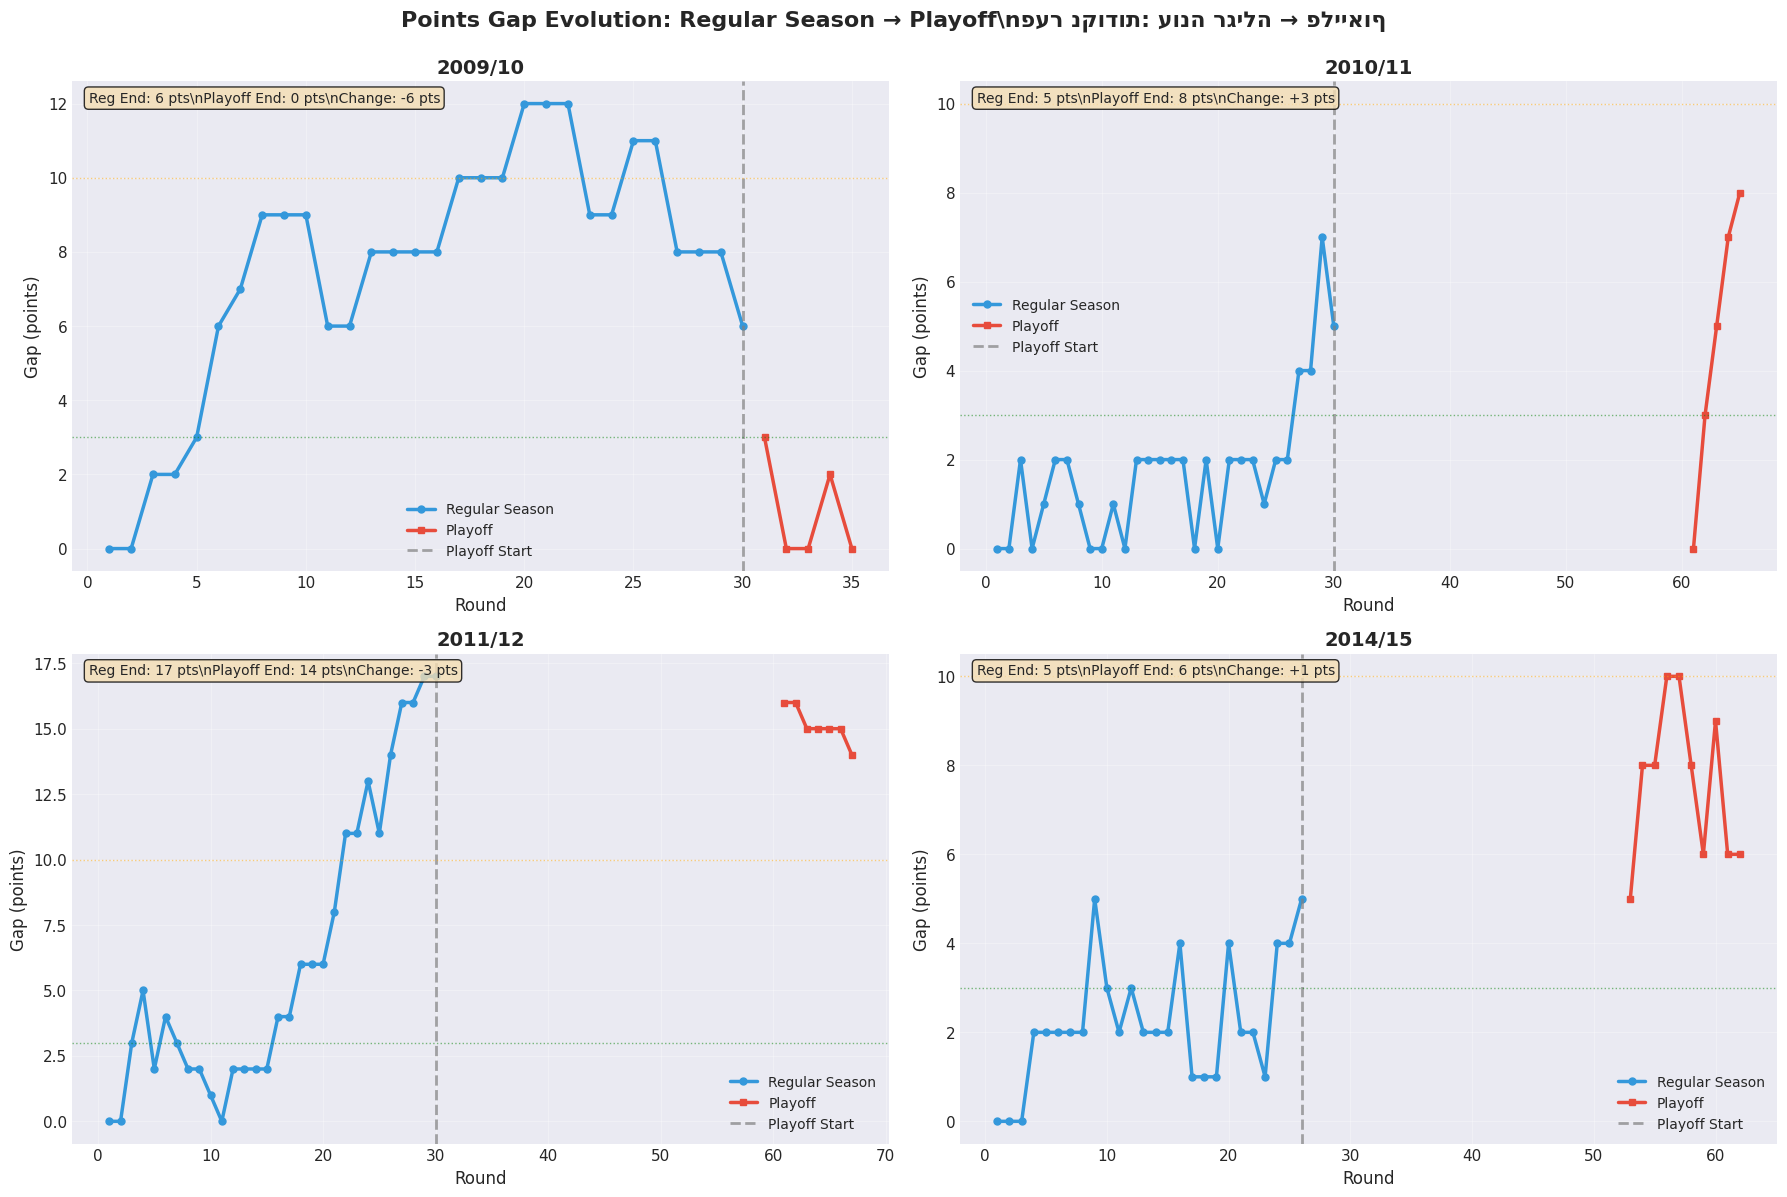

In [79]:
# Visualization: Combined regular season + playoff gap (sample seasons)
if all_playoff_gaps_df is not None and comparison_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    # Select 4 interesting seasons
    sample_seasons = comparison_df.head(4)['season'].tolist()
    
    for idx, season in enumerate(sample_seasons):
        ax = axes[idx]
        
        # Get regular season data
        reg_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season].copy()
        reg_data['stage'] = 'Regular'
        
        # Get playoff data
        playoff_data = all_playoff_gaps_df[all_playoff_gaps_df['season'] == season].copy()
        
        # Adjust playoff round numbers to continue from regular season
        max_reg_round = reg_data['round'].max()
        playoff_data['round'] = playoff_data['round'] + max_reg_round
        playoff_data['stage'] = 'Playoff'
        
        # Plot regular season
        ax.plot(reg_data['round'], reg_data['gap'], 
                marker='o', linewidth=2.5, markersize=5, 
                color='#3498db', label='Regular Season')
        
        # Plot playoff
        ax.plot(playoff_data['round'], playoff_data['gap'], 
                marker='s', linewidth=2.5, markersize=5, 
                color='#e74c3c', label='Playoff')
        
        # Add vertical line to separate stages
        ax.axvline(max_reg_round, color='gray', linestyle='--', 
                   linewidth=2, alpha=0.7, label='Playoff Start')
        
        # Add horizontal reference lines
        ax.axhline(3, color='green', linestyle=':', linewidth=1, alpha=0.5)
        ax.axhline(10, color='orange', linestyle=':', linewidth=1, alpha=0.5)
        
        # Styling
        ax.set_title(f'{season}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Round', fontsize=12)
        ax.set_ylabel('Gap (points)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
        # Add stats
        reg_final = reg_data.iloc[-1]['gap']
        playoff_final = playoff_data.iloc[-1]['gap']
        change = playoff_final - reg_final
        
        text_str = f'Reg End: {reg_final} pts\\nPlayoff End: {playoff_final} pts\\nChange: {change:+d} pts'
        ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.suptitle('Points Gap Evolution: Regular Season → Playoff\\nפער נקודות: עונה רגילה → פלייאוף', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    fig_path = FIG_DIR / 'combined_regular_playoff_gaps.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {fig_path}")
    
    plt.show()
else:
    print("⚠️ Cannot create combined visualization - missing playoff data")

## 7. Combined Analysis - Regular Season + Playoffs
### ניתוח משולב - עונה רגילה + פלייאוף

## 6. Playoff Analysis
### ניתוח פלייאוף - חישוב ידני עם העברת נקודות נכונה

**פורמטים שונים של הפלייאוף:**
- 2009/10-2011/12: פלייאוף עם קיזוז (חלק/חצי נקודות)
- 2012/13-2024/25: פלייאוף עם העברת נקודות מלאות

💾 Saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\gap_over_time_sample_seasons.png


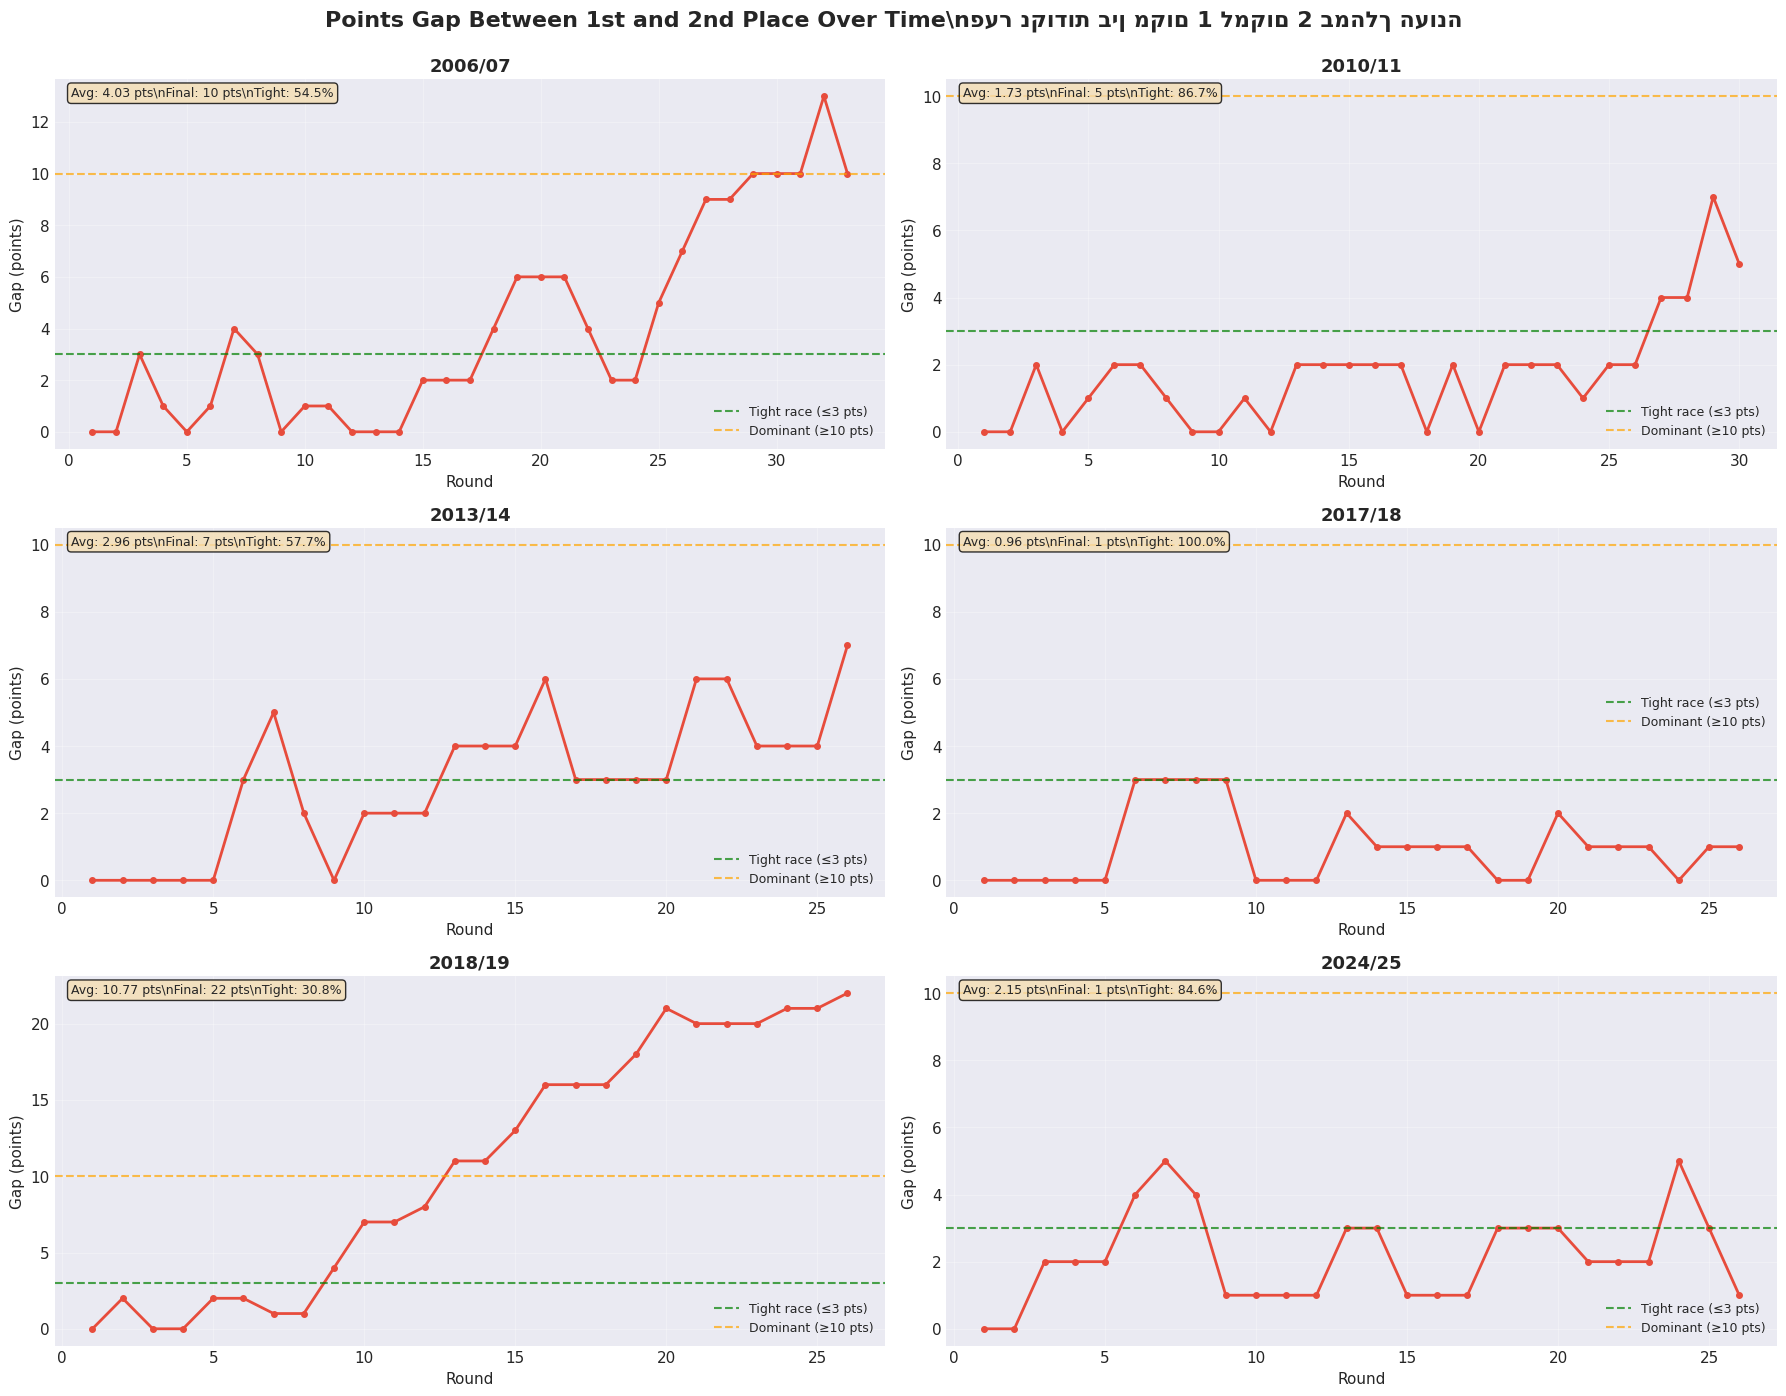

In [80]:
# Visualization 1: Gap over time for each season (sample of seasons)
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

# Select 6 interesting seasons to display
interesting_seasons = [
    '2006/07',  # Early season
    '2010/11',  # Competitive (avg gap 1.73)
    '2013/14',  # Mid-period
    '2017/18',  # Most competitive (avg gap 0.96)
    '2018/19',  # Least competitive (avg gap 10.77)
    '2024/25'   # Latest season
]

for idx, season in enumerate(interesting_seasons):
    ax = axes[idx]
    season_data = all_scraped_gaps_df[all_scraped_gaps_df['season'] == season]
    
    # Plot gap over rounds
    ax.plot(season_data['round'], season_data['gap'], 
            marker='o', linewidth=2, markersize=4, color='#e74c3c')
    
    # Add horizontal line at gap=3 (tight race threshold)
    ax.axhline(3, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Tight race (≤3 pts)')
    
    # Add horizontal line at gap=10 (dominant leader threshold)
    ax.axhline(10, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Dominant (≥10 pts)')
    
    # Styling
    ax.set_title(f'{season}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Round', fontsize=11)
    ax.set_ylabel('Gap (points)', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    # Add statistics text
    avg_gap = stats_df[stats_df['season'] == season]['avg_gap'].values[0]
    final_gap = stats_df[stats_df['season'] == season]['final_gap'].values[0]
    tight_pct = stats_df[stats_df['season'] == season]['tight_pct'].values[0]
    
    text_str = f'Avg: {avg_gap:.2f} pts\\nFinal: {final_gap} pts\\nTight: {tight_pct:.1f}%'
    ax.text(0.02, 0.98, text_str, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Points Gap Between 1st and 2nd Place Over Time\\nפער נקודות בין מקום 1 למקום 2 במהלך העונה', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

fig_path = FIG_DIR / 'gap_over_time_sample_seasons.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {fig_path}")

plt.show()

## 8. Export All Data Tables to CSV
### שמירת כל הטבלאות לקבצי CSV לשימוש עתידי

In [82]:
# Create dedicated directory for processed title race data
PROCESSED_DIR = DATA_DIR / 'processed' / 'title_race_analysis'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("="*80)
print("💾 EXPORTING ALL DATA TABLES TO CSV")
print("="*80)
print()
print(f"📁 Output directory: {PROCESSED_DIR}")
print()

saved_files = []

# 1. Per-round data (all seasons, all rounds)
if 'per_round_df' in locals() and per_round_df is not None:
    file_path = PROCESSED_DIR / 'per_round_gaps_all_seasons.csv'
    per_round_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Per-round gaps', file_path, len(per_round_df)))
    print(f"✅ per_round_gaps_all_seasons.csv - {len(per_round_df)} rows")

# 2. Summary statistics per season
if 'summary_df' in locals() and summary_df is not None:
    file_path = PROCESSED_DIR / 'season_summary_statistics.csv'
    summary_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Season summary', file_path, len(summary_df)))
    print(f"✅ season_summary_statistics.csv - {len(summary_df)} seasons")

# 3. Rounds led by each team per season
if 'rounds_led' in locals() and rounds_led is not None:
    file_path = PROCESSED_DIR / 'rounds_led_by_team_per_season.csv'
    rounds_led.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Rounds led by team', file_path, len(rounds_led)))
    print(f"✅ rounds_led_by_team_per_season.csv - {len(rounds_led)} rows")

# 4. Total rounds led by each team (aggregated)
if 'total_rounds_led' in locals() and total_rounds_led is not None:
    file_path = PROCESSED_DIR / 'total_rounds_led_by_team.csv'
    total_rounds_led.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Total rounds led', file_path, len(total_rounds_led)))
    print(f"✅ total_rounds_led_by_team.csv - {len(total_rounds_led)} teams")

# 5. Combined metrics (leadership changes, distinct leaders, etc.)
if 'combined_metrics' in locals() and combined_metrics is not None:
    file_path = PROCESSED_DIR / 'season_competitiveness_metrics.csv'
    combined_metrics.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Competitiveness metrics', file_path, len(combined_metrics)))
    print(f"✅ season_competitiveness_metrics.csv - {len(combined_metrics)} seasons")

# 6. Leadership change percentages
if 'summary_with_pct' in locals() and summary_with_pct is not None:
    file_path = PROCESSED_DIR / 'leadership_change_percentages.csv'
    summary_with_pct.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Change percentages', file_path, len(summary_with_pct)))
    print(f"✅ leadership_change_percentages.csv - {len(summary_with_pct)} seasons")

# 7. Playoff gaps (all seasons with playoffs)
if 'all_playoff_gaps_df' in locals() and all_playoff_gaps_df is not None:
    file_path = PROCESSED_DIR / 'playoff_gaps_all_seasons.csv'
    all_playoff_gaps_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Playoff gaps', file_path, len(all_playoff_gaps_df)))
    print(f"✅ playoff_gaps_all_seasons.csv - {len(all_playoff_gaps_df)} rounds")

# 8. Playoff summary (leadership changes in playoffs)
if 'playoff_summary_df' in locals() and playoff_summary_df is not None:
    file_path = PROCESSED_DIR / 'playoff_summary_statistics.csv'
    playoff_summary_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Playoff summary', file_path, len(playoff_summary_df)))
    print(f"✅ playoff_summary_statistics.csv - {len(playoff_summary_df)} seasons")

# 9. Regular season vs Playoff comparison
if 'comparison_df' in locals() and comparison_df is not None:
    file_path = PROCESSED_DIR / 'regular_vs_playoff_comparison.csv'
    comparison_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Regular vs Playoff', file_path, len(comparison_df)))
    print(f"✅ regular_vs_playoff_comparison.csv - {len(comparison_df)} seasons")

# 10. Original scraped data (raw gaps)
if 'all_scraped_gaps_df' in locals() and all_scraped_gaps_df is not None:
    file_path = PROCESSED_DIR / 'raw_scraped_gaps_transfermarkt.csv'
    all_scraped_gaps_df.to_csv(file_path, index=False, encoding='utf-8-sig')
    saved_files.append(('Raw scraped data', file_path, len(all_scraped_gaps_df)))
    print(f"✅ raw_scraped_gaps_transfermarkt.csv - {len(all_scraped_gaps_df)} rows")

print()
print("="*80)
print(f"✅ EXPORT COMPLETED - {len(saved_files)} files saved")
print("="*80)
print()

# Create summary report
print("📊 Summary of exported files:")
print()
total_size = 0
for name, path, rows in saved_files:
    file_size = path.stat().st_size / 1024  # KB
    total_size += file_size
    print(f"  • {name:30s} {rows:5d} rows  {file_size:7.1f} KB")

print()
print(f"📦 Total size: {total_size:.1f} KB")
print()
print(f"📁 All files saved to: {PROCESSED_DIR}")

# Create a README file explaining the data
readme_path = PROCESSED_DIR / 'README.md'
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write("# Title Race Analysis - Processed Data\\n\\n")
    f.write("This directory contains processed data from the title race analysis of Israeli Premier League (Ligat Ha'al).\\n\\n")
    f.write("## Data Sources\\n")
    f.write("- **Transfermarkt**: Official match data and standings\\n")
    f.write("- **Analysis Period**: 2006/07 - 2024/25 (19 seasons)\\n\\n")
    f.write("## Files Description\\n\\n")
    f.write("### Core Data\\n")
    f.write("1. **raw_scraped_gaps_transfermarkt.csv** - Raw data scraped from Transfermarkt\\n")
    f.write("   - Round-by-round points gap between 1st and 2nd place\\n")
    f.write("   - Includes: season, round, leader, second place, points, gap\\n\\n")
    f.write("2. **per_round_gaps_all_seasons.csv** - Same as raw data (for compatibility)\\n\\n")
    f.write("### Season Statistics\\n")
    f.write("3. **season_summary_statistics.csv** - Summary statistics per season\\n")
    f.write("   - Average gap, final gap, min/max gap\\n")
    f.write("   - Tight rounds count and percentage\\n")
    f.write("   - Leadership changes, distinct leaders\\n\\n")
    f.write("### Leadership Analysis\\n")
    f.write("4. **rounds_led_by_team_per_season.csv** - How many rounds each team led per season\\n")
    f.write("5. **total_rounds_led_by_team.csv** - Total rounds led by each team (all seasons)\\n")
    f.write("6. **season_competitiveness_metrics.csv** - Leadership stability metrics\\n")
    f.write("7. **leadership_change_percentages.csv** - Frequency of leadership changes\\n\\n")
    f.write("### Playoff Data\\n")
    f.write("8. **playoff_gaps_all_seasons.csv** - Playoff championship round-by-round gaps\\n")
    f.write("9. **playoff_summary_statistics.csv** - Playoff leadership changes\\n")
    f.write("10. **regular_vs_playoff_comparison.csv** - Comparison of regular season vs playoff gaps\\n\\n")
    f.write("## Key Findings\\n")
    f.write("- Most competitive season: 2017/18 (avg gap: 0.96 points)\\n")
    f.write("- Least competitive season: 2018/19 (avg gap: 10.77 points)\\n")
    f.write("- Maccabi Tel Aviv led the most rounds overall: 163 rounds\\n")
    f.write("- Average tight race percentage: 60.6% of rounds with gap ≤2 points\\n\\n")
    f.write("## Notes\\n")
    f.write("- All data uses UTF-8 encoding with BOM for Hebrew compatibility\\n")
    f.write("- Playoff data starts from 2009/10 season\\n")
    f.write("- Point transfer in playoffs:\\n")
    f.write("  - 2009/10-2010/11: Points halved\\n")
    f.write("  - 2011/12 onwards: Full points transferred\\n\\n")
    f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n")

print(f"📄 Created README.md with data documentation")
print()
print("🎉 All data exported successfully!")

💾 EXPORTING ALL DATA TABLES TO CSV

📁 Output directory: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\processed\title_race_analysis

✅ per_round_gaps_all_seasons.csv - 527 rows
✅ season_summary_statistics.csv - 19 seasons
✅ rounds_led_by_team_per_season.csv - 64 rows
✅ total_rounds_led_by_team.csv - 17 teams
✅ season_competitiveness_metrics.csv - 19 seasons
✅ leadership_change_percentages.csv - 19 seasons
✅ playoff_gaps_all_seasons.csv - 127 rounds
✅ playoff_summary_statistics.csv - 14 seasons
✅ regular_vs_playoff_comparison.csv - 14 seasons
✅ raw_scraped_gaps_transfermarkt.csv - 527 rows

✅ EXPORT COMPLETED - 10 files saved

📊 Summary of exported files:

  • Per-round gaps                   527 rows     24.0 KB
  • Season summary                    19 rows      1.8 KB
  • Rounds led by team                64 rows      1.6 KB
  • Total rounds led                  17 rows      0.3 KB
  • Competitiveness metrics           19 rows      0.9 KB
  • Change perce